## Imports

In [1]:
from fastai import *
import numpy as np
import torch
import torch.utils.data as torchdata
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from skimage import draw
import matplotlib.pyplot as plt
import pdb
from fastai import *

import aggdraw
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence

%matplotlib inline

## Bezier data generation

In [14]:
def bezier2image(bez, image_shape):
    img = Image.new("L", image_shape, "black")
    canvas = aggdraw.Draw(img)
    pen = aggdraw.Pen("white")
    path = aggdraw.Path()
    path.moveto(*bez[0:2])
    path.curveto(*bez)
    canvas.path(path, path.coords(), pen)
    canvas.flush()
    arr = np.array(img)/255.
    return arr

In [15]:
def generate_render_sequence(count, action_shape, action_scaler, render_shape, prefix, min_seq_len= 5, max_seq_len=5, keep_intermediate=False, seed=123):
    rs = np.random.RandomState(seed=seed)
    index = pd.DataFrame({'image_name':[], 'seq_idx':[], 'act_idx':[], 'actions':[], 'action':[]})
    seq_lens = rs.randint(min_seq_len, max_seq_len+1, (count,))
    for seq_idx in progress_bar(range(count)):
        seq_len = seq_lens[seq_idx]
        actions = rs.rand(seq_len, *action_shape)
        render = np.zeros(render_shape)
        img = Image.new("L", render_shape, "black")
        canvas = aggdraw.Draw(img)
        pen = aggdraw.Pen("white")
        for act_idx in range(seq_len):
            bez = actions[act_idx] * action_scaler
            path = aggdraw.Path()
            path.moveto(*bez[0:2])
            path.curveto(*bez)
            canvas.path(path, path.coords(), pen)
            if keep_intermediate:
                canvas.flush()
                arr = np.array(img)/255.
                fname = f"{prefix}{seq_idx}-{act_idx}.npy"
                np.save(fname, arr)
                index = index.append({
                    'image_name': fname, 
                    'seq_idx': seq_idx, 
                    'act_idx': act_idx, 
                    'actions': actions[0:act_idx+1], 
                    'action':actions[act_idx]},
                    ignore_index=True
                )
        if not keep_intermediate:
            canvas.flush()
            arr = np.array(img)/255.
            fname = f"{prefix}{seq_idx}.npy"
            np.save(fname, arr)
            index = index.append({
                'image_name': fname, 
                'seq_idx': seq_idx, 
                'act_idx': act_idx, 
                'actions': actions[0:act_idx+1], 
                'action':actions[act_idx]},
                ignore_index=True
            )
    return index

In [16]:
def generate_canvas_df(count):    
    render_index = generate_render_sequence(count, (6,), 64, (64, 64), 'data/canvas/', 1, 5, True)
    
    canvas_df = (
        render_index
        .sort_values(['seq_idx', 'act_idx'])
        .assign(prev_image_name=render_index.shift(1).image_name)
    )
    canvas_df.loc[canvas_df.act_idx == 0, 'prev_image_name'] = None
    
    return canvas_df[['image_name', 'prev_image_name', 'action']]

In [17]:
def generate_drawer_df(count):    
    render_index = generate_render_sequence(count, (6,), 64, (64, 64), 'data/drawer/', 5, 5)
    return render_index[['image_name']]

In [18]:
#drawer_df = generate_drawer_df(20000)
#canvas_df.to_csv('canvas_df')
#drawer_df.to_csv('drawer_df.csv')

In [19]:
canvas_df = pd.read_csv('canvas_df.csv')
canvas_df.action = canvas_df.action.map(lambda a: pd.to_numeric(a[1:-1].split()))
drawer_df = pd.read_csv('drawer_df.csv')

## Dataset classes

In [20]:
class CanvasDataset(Dataset):
    def __init__(self, canvas_df):
        self.count = len(canvas_df)
        self.df = canvas_df.reset_index()
    def __len__(self):
        return self.count
    def __getitem__(self, idx):
        item = self.df.loc[idx]
        prev = item.prev_image_name
        image = torch.tensor(np.load(item.image_name), dtype=torch.float).unsqueeze(0)
        hint = torch.tensor(np.load(prev), dtype=torch.float).unsqueeze(0) if prev is not np.nan else torch.zeros_like(image)
        action = torch.tensor(item.action, dtype=torch.float)
        return (hint, action), image

In [21]:
class DrawerDataset(Dataset):
    def __init__(self, drawer_df):
        self.count = len(drawer_df)
        self.df = drawer_df.reset_index()
    def __len__(self):
        return self.count
    def __getitem__(self, idx):
        item = self.df.loc[idx]
        image = torch.tensor(np.load(item.image_name), dtype=torch.float).unsqueeze(0)
        return image, image

In [22]:
class MNISTUnsupervisedDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mn = mnist_dataset
    def __len__(self):
        return len(self.mn)
    def __getitem__(self, idx):
        im = self.mn[idx][0]
        return im, im

In [23]:
mnist_transforms = transforms.Compose([
    transforms.Pad((18, 18)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda ts: ts.unsqueeze(0))
])

mnist_train_loader = MNISTUnsupervisedDataset(
    datasets.MNIST(
        '../data', 
        train=True, 
        transform=mnist_transforms
    )
)
mnist_test_loader = MNISTUnsupervisedDataset(
    datasets.MNIST(
        '../data', 
        train=False, 
        transform=mnist_transforms
    )
)

## Shared layer definitions and model functions

In [24]:
def ConvPyramid():
    return nn.Sequential(
        nn.Conv2d(3, 4, 3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(4, 8, 3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(8, 32, 3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
    )

In [25]:
def ConvLayer(in_channels, out_channels, kernel_size, stride, last=False):
    pad_a = kernel_size // 2
    pad_b = (pad_a - 1) if kernel_size % 2 == 0 else pad_a
    return nn.Sequential(OrderedDict([
        ('pad', nn.ZeroPad2d((pad_a, pad_b, pad_a, pad_b))),
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    ] + ([] if last else [('relu', nn.ReLU())])))

In [26]:
class ResCube(nn.Module):
    def __init__(self, dim):
        super().__init__() 
        self.conv = nn.Sequential(
            nn.Conv2d(dim, dim, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim, dim, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        out = self.conv(x)
        return x + out
   

In [27]:
def Convup2x(in_dim, last=False):
    return nn.Sequential(OrderedDict([
        ('convT', nn.ConvTranspose2d(in_dim, 2 * in_dim, 3, stride=2, padding=1, output_padding=1))
    ] + ([] if last else [('relu', nn.LeakyReLU(0.2))])))

In [28]:
def get_coord(image_dim, batch_size):
    coord = (torch
     .linspace(-1, 1, image_dim, dtype=torch.float)
     .cuda()
     .unsqueeze(0)
     .repeat((image_dim, 1))
     .unsqueeze(0)) # linear range layer of 1 x H x W

    return (((torch.cat((coord, coord.transpose(1,2)), 0)))
            .unsqueeze(0)
            .repeat((batch_size, 1, 1, 1))) # i, j coord layer of B x(C=2) x H x W

## Preview functions

In [92]:
def preview_canvas_withhint_logits(ds, learn, image_sz=64):
    it = iter(ds)
    fig, ax = plt.subplots(10,4, figsize = (8, 16))
    for i, ax in enumerate(ax):
        (hint, action), ground = next(it)
        args = hint.cuda().unsqueeze(0),action.cuda().unsqueeze(0)
        logits = learn.model.logits(*args)
        ax[0].imshow(torch.sigmoid(logits).detach().cpu().numpy().reshape((image_sz,image_sz)))
        ax[0].set_title('generated image')
        ax[1].imshow(logits.detach().cpu().numpy().reshape((image_sz,image_sz)))
        ax[1].set_title('logits')
        ax[2].imshow(ground.reshape((image_sz,image_sz)))
        ax[2].set_title('target + bezier input')
        ax[2].scatter(action[0::2]*image_sz, action[1::2]*image_sz)
        ax[3].imshow(hint.detach().reshape((64,64)))
        ax[3].set_title('hint input')

In [103]:
def preview_canvas(ds, learn):
    it = iter(ds)
    fig, ax = plt.subplots(10,3, figsize = (8, 20), squeeze=False)
    for i, ax in enumerate(ax):
        action, ground = next(it)
        outputs = learn.model(
            action.cuda().unsqueeze(0)
        ).detach().cpu().numpy()
        ax[0].imshow(outputs.reshape((64,64)))
        ax[1].imshow(outputs.round().reshape((64,64)))
        ax[2].imshow(ground.reshape((64,64)))

## Original Canvas network implementation

### Definitions

In [2]:
class Canvas(nn.Module):
    def __init__(self, action_dim, image_dim):
        super().__init__() 
        self.action_dim = action_dim
        self.action_dim = action_dim
        self.conv_action = nn.Sequential(
            nn.Linear(action_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 8 ** 3),
            nn.LeakyReLU(0.2),
            Lambda(lambda x: x.reshape(-1, 8, 8, 8)),
            Convup2x(8,),
            Convup2x(16,),
        )
        
        self.conv_hint = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.conv2cubes = nn.Sequential(
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.rescubes = nn.Sequential(
            ResCube(32),
            ResCube(32),
            ResCube(32),
        )
        
        self.deconv = nn.ConvTranspose2d(32, 1, 3, stride = 2, padding=1, output_padding=1)
        
    def logits(self, hint, action):
        action_out = self.conv_action(action)
        #hint_aug = torch.cat((hint, get_coord(self.image_dim, hint.shape[0])), 1)
        hint_out = self.conv_hint(hint)
        out = torch.cat((action_out, hint_out), 1)
        out = self.conv2cubes(out)
        out = self.rescubes(out)
        out = self.deconv(out)
        return out
    def forward(self, hint, action):
        out = self.logits(hint, action)
        return torch.sigmoid(out)

In [3]:
def get_canvas_learner(dataset_df, image_size):
    split = int(len(dataset_df) * 0.8)
    canv_train_ds = CanvasDataset(dataset_df[:split])
    canv_valid_ds = CanvasDataset(dataset_df[split:])
    canv_db = DataBunch.create(canv_train_ds, canv_valid_ds, bs=64)
    canv_learn = Learner(
        canv_db, 
        Canvas(6, image_size).cuda(),
        callback_fns=ShowGraph, 
        loss_fn=F.binary_cross_entropy,
        wd=0.001
    )
    return canv_learn

### Training

In [86]:
canv_learn = get_canvas_learner(canvas_df, (64,64))

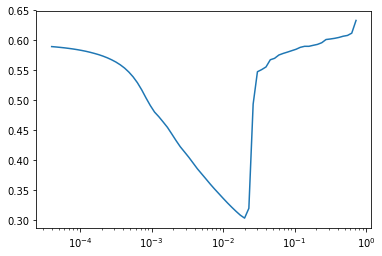

In [20]:
canv_learn.lr_find()
canv_learn.recorder.plot()

Total time: 08:12
epoch  train loss  valid loss
0      0.061454    0.060924    (00:19)
1      0.052541    0.052436    (00:19)
2      0.047087    0.047665    (00:19)
3      0.044078    0.044319    (00:19)
4      0.041682    0.042860    (00:19)
5      0.040181    0.040130    (00:19)
6      0.039792    0.042461    (00:19)
7      0.038371    0.039961    (00:19)
8      0.038105    0.038182    (00:19)
9      0.036569    0.036391    (00:19)
10     0.035672    0.036771    (00:19)
11     0.034676    0.036892    (00:19)
12     0.034232    0.034270    (00:20)
13     0.033791    0.033529    (00:20)
14     0.032995    0.035092    (00:20)
15     0.032274    0.032819    (00:19)
16     0.031703    0.032230    (00:19)
17     0.031222    0.031181    (00:19)
18     0.030402    0.031155    (00:19)
19     0.030227    0.030750    (00:19)
20     0.029611    0.030275    (00:19)
21     0.029236    0.029913    (00:19)
22     0.029119    0.029757    (00:20)
23     0.028972    0.029687    (00:19)
24     0.028933 

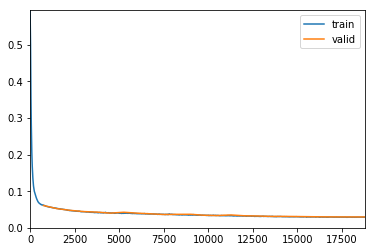

In [21]:
canv_learn.fit_one_cycle(25)

In [87]:
canv_learn.load('canv-gooddata-20kseq-25xonecycle')

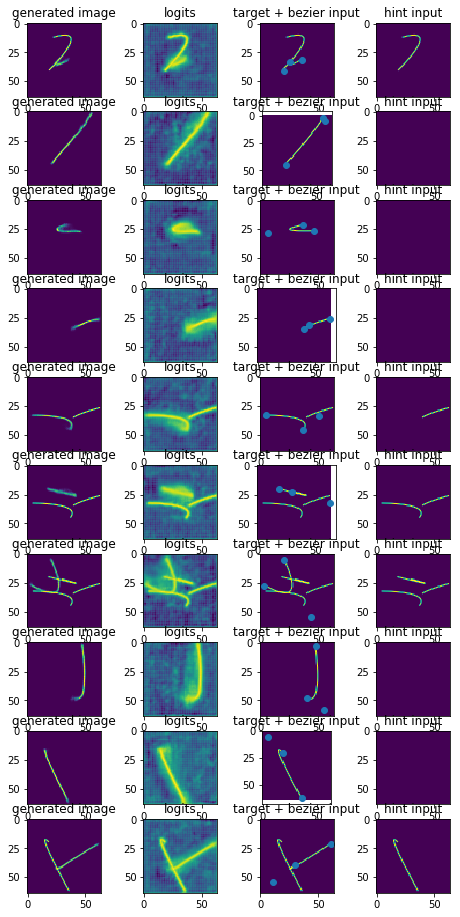

In [104]:
preview_canvas_withhint_logits(CanvasDataset(canvas_df[-20:]), canv_learn)

In [23]:
canv_learn.save('canv-gooddata-20kseq-25xonecycle')

## CoordConv Canvas implementation

### Definitions

In [4]:
class CoordCanvas(nn.Module):
    def __init__(self, action_dim, image_dim):
        super().__init__() 
        self.action_dim = action_dim
        self.image_dim = image_dim
        
        self.conv2cubes = ConvLayer(3+action_dim, image_dim//2, kernel_size=3, stride=1)
        
        self.rescubes = nn.Sequential(
            ResCube(image_dim//2),
            ResCube(image_dim//2),
            ResCube(image_dim//2),
        )
        
        self.conv_final = ConvLayer(image_dim//2, 1, kernel_size=3, stride=1, last=True)        
        
    def logits(self, hint, action):
        """
            action - 2d tensor of shape B x D (where D = action_dim)
        """
        B = action.shape[0]
        out = action.reshape((B, self.action_dim, 1, 1))
        out = out.repeat((1, 1, self.image_dim, self.image_dim))
        
        # tiled action layer of B x (C=action_dim) x H x W
        coord = get_coord(self.image_dim, B)
        out = (
            torch.cat((coord, hint, out), 1)
        ) # concatenated coordconv input of B x (C=3+action_dim) x H x W
        out = self.conv2cubes(out)
        out = self.rescubes(out)
        out = self.conv_final(out)
        return out
    
    def forward(self, hint, action):
        out = self.logits(hint, action)
        final = torch.sigmoid(out)
        return final

In [5]:
def get_coordcanv_learner(dataset_df, image_size, action_size):
    split = int(len(dataset_df) * 0.8)
    coordcanv_train_ds = CanvasDataset(dataset_df[:split])
    coordcanv_valid_ds = CanvasDataset(dataset_df[split:])
    coordcanv_db = DataBunch.create(coordcanv_train_ds, coordcanv_valid_ds, bs=64)
    coordcanv_learn = Learner(
        coordcanv_db, 
        CoordCanvas(action_size, image_size).cuda(),
        callback_fns=ShowGraph, 
        loss_fn=F.binary_cross_entropy,
        wd=0.001
    )
    return coordcanv_learn

### Training

In [24]:
coordcanv_learn = get_coordcanv_learner(canvas_df, 64, 6)

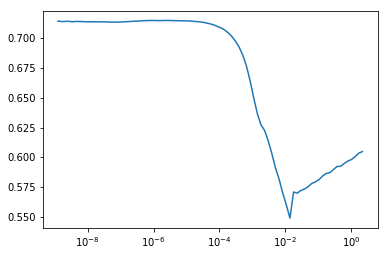

In [25]:
coordcanv_learn.lr_find(1e-10)
coordcanv_learn.recorder.plot()

Total time: 11:28
epoch  train loss  valid loss
0      0.059352    0.058049    (00:27)
1      0.049775    0.051683    (00:27)
2      0.045333    0.045135    (00:28)
3      0.041057    0.039991    (00:26)
4      0.038647    0.039418    (00:27)
5      0.039229    0.040865    (00:27)
6      0.039656    0.042455    (00:27)
7      0.038446    0.038069    (00:27)
8      0.036643    0.037863    (00:28)
9      0.035270    0.033492    (00:27)
10     0.034223    0.033255    (00:27)
11     0.032855    0.033637    (00:27)
12     0.032431    0.035387    (00:27)
13     0.030987    0.032377    (00:27)
14     0.029512    0.029847    (00:27)
15     0.028700    0.030532    (00:27)
16     0.027525    0.027489    (00:27)
17     0.027591    0.027425    (00:27)
18     0.026715    0.026906    (00:27)
19     0.026450    0.026406    (00:27)
20     0.026450    0.026551    (00:27)
21     0.026298    0.026186    (00:27)
22     0.026132    0.026075    (00:27)
23     0.025811    0.025999    (00:27)
24     0.025959 

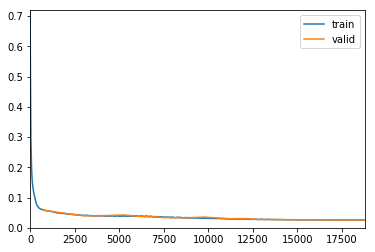

In [26]:
coordcanv_learn.fit_one_cycle(25)

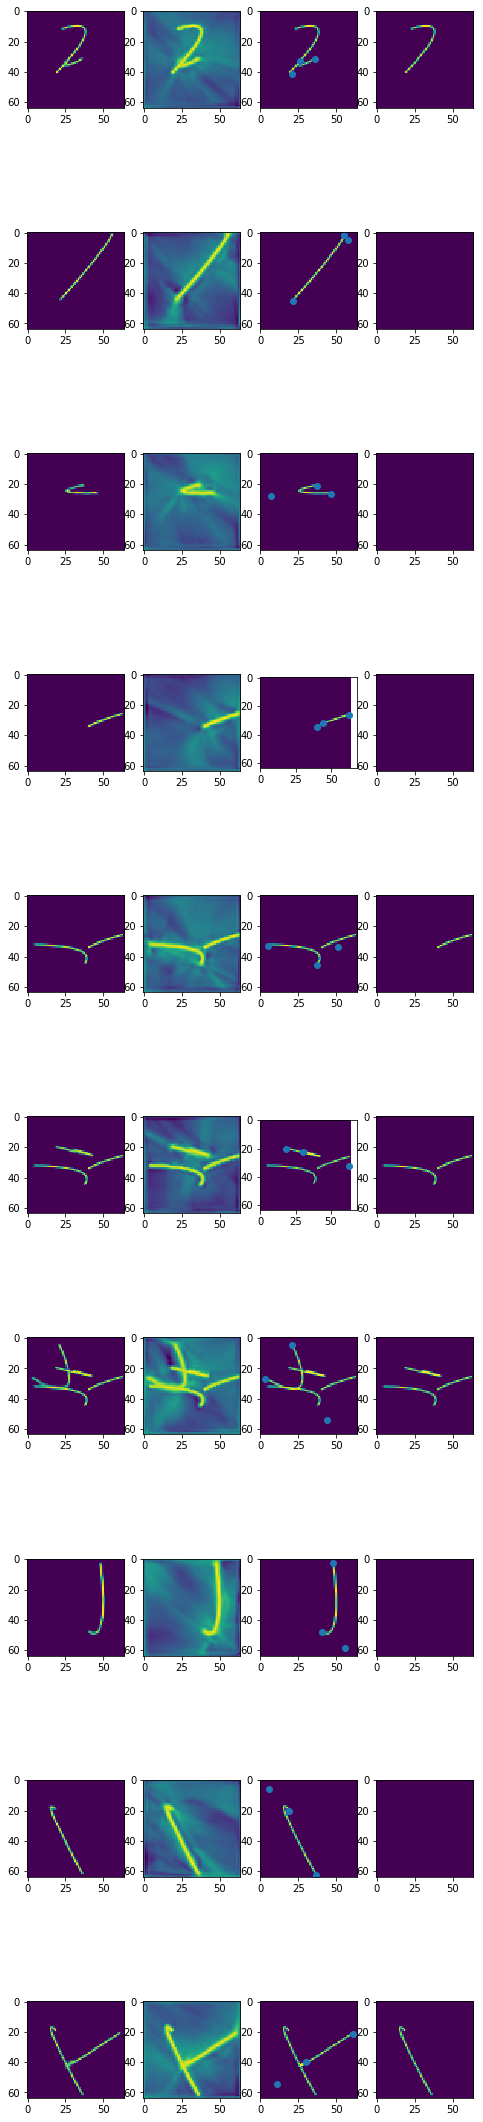

In [31]:
preview_canvas_withhint_logits(CanvasDataset(canvas_df[-20:]), coordcanv_learn)

In [32]:
coordcanv_learn.save('coordcanv-gooddata-20k-25xonecycle')

## Original Drawer Implementation 

### Definitions

In [6]:
class Drawer(nn.Module):
    def __init__(self, action_dim, timesteps, canvas_model):
        super().__init__()
        self.canvas_model = canvas_model
        self.action_dim = action_dim
        self.timesteps = timesteps
        self.image_convs = ConvPyramid()
        self.hint_convs = ConvPyramid()
        self.fcs = nn.Sequential(
            Flatten(),
            nn.Linear(8*8*32*2, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
        )
        
        self.rnn_size = 128
        self.nl = 1
        self.rnn = nn.LSTM(128, self.rnn_size, 1, batch_first = True)
        self.fcs_final = nn.Linear(self.rnn_size, action_dim)
        for p in canvas_model.parameters():
            p.requires_grad_(False)

    def init_hidden(self, bs):
        self.hidden = torch.zeros((self.nl, bs, self.rnn_size)).cuda()

    def forward(self, hint):
        bs = hint.shape[0]
        self.canvas_model.eval()
        self.init_hidden(bs)      
        image_in = torch.zeros_like(hint).cuda()
        actions = torch.zeros((bs, self.timesteps, self.action_dim)).cuda()
        for idx in range(self.timesteps):
            coord = get_coord(hint.shape[-1], bs)

            image_out = torch.cat(
                (image_in, coord), 1
            )
            hint_out = torch.cat(
                (hint, coord), 1
            )
            
            image_out = self.image_convs(image_out)
            hint_out = self.image_convs(hint_out)
        
            out = torch.cat((image_out, hint_out), 1)
            out = self.fcs(out)
            out, (self.hidden, _) = self.rnn(out.unsqueeze(1), (self.hidden, torch.zeros_like(self.hidden).cuda()))
            action = torch.sigmoid(self.fcs_final(out)).reshape((bs, self.action_dim))      
            render = self.canvas_model(image_in, action)
            actions[:, idx] = action
            image_in = torch.max(image_in, render)
        return image_in, actions

In [7]:
import matplotlib.patches as mpatches
import matplotlib.path as mpath
Path = mpath.Path

In [9]:
def image_action_loss(output, target):
    ims, acts = output
    return F.binary_cross_entropy(ims, target)

In [10]:
def get_drawer_learner(dataset_df, image_size, action_size):
    canvas_learner = get_canvas_learner(canvas_df, image_size)
    canvas_learner.load('canv-gooddata-20kseq-25xonecycle')
    split = int(len(dataset_df) * 0.8)
    drawer_train_ds = DrawerDataset(dataset_df[:split])
    drawer_valid_ds = DrawerDataset(dataset_df[split:])
    drawer_db = DataBunch.create(drawer_train_ds, drawer_valid_ds, bs=256)
    drawer_learn = Learner(
        drawer_db, 
        Drawer(action_size, 5, canvas_learner.model).cuda(),
        callback_fns=ShowGraph, 
        loss_fn=image_action_loss,
    )
    return drawer_learn, drawer_train_ds, drawer_valid_ds

In [11]:
class SaveModel(LearnerCallback):
    "Incrementally save the model and plot results."
    def on_epoch_end(self, epoch, **kwargs):
        "If we have metrics plot them in our pbar graph"
        if epoch % 5 == 0:
            self.learn.save(f'current-model-{epoch}')
            plot_drawer_actions(drawer_learn, iter(self.learn.data.valid_dl))

### Training

#### MNIST reconstruction task

In [31]:
canvas_learner = get_canvas_learner(canvas_df, 64)
canvas_learner.load('canv-gooddata-20kseq-25xonecycle')

drawer_db = DataBunch.create(mnist_train_loader, mnist_test_loader, bs=64)
drawer_learn = Learner(
    drawer_db, 
    Drawer(6, 4, canvas_learner.model).cuda(),
    callback_fns=ShowGraph, 
    loss_fn=image_action_loss,
)

/home/wgoldie/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/wgoldie/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Total time: 53:33
epoch  train loss  valid loss
0      0.027398    0.029349    (01:02)
1      0.027330    0.026662    (01:04)
2      0.027177    0.025815    (01:03)
3      0.025222    0.026820    (01:03)
4      0.025114    0.025319    (01:04)
5      0.026351    0.026294    (01:03)
6      0.026753    0.026812    (01:04)
7      0.025442    0.025494    (01:04)
8      0.026752    0.025979    (01:03)
9      0.025746    0.025811    (01:03)
10     0.025020    0.024901    (01:03)
11     0.025333    0.026630    (01:04)
12     0.026047    0.026867    (01:04)
13     0.025979    0.025828    (01:04)
14     0.027669    0.026076    (01:03)
15     0.026297    0.025647    (01:03)
16     0.027902    0.026199    (01:04)
17     0.026417    0.026243    (01:03)
18     0.024716    0.024591    (01:03)
19     0.026765    0.028327    (01:03)
20     0.024661    0.024652    (01:03)
21     0.026581    0.025629    (01:04)
22     0.024827    0.024602    (01:03)
23     0.026529    0.025983    (01:04)
24     0.024764 

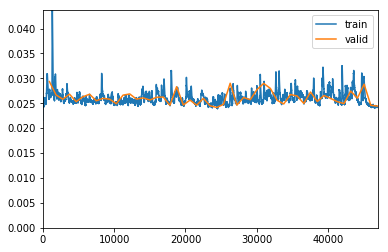

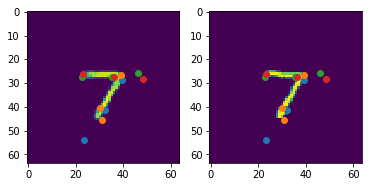

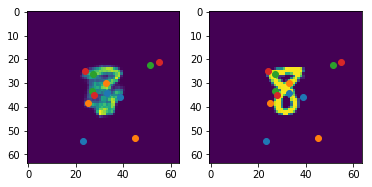

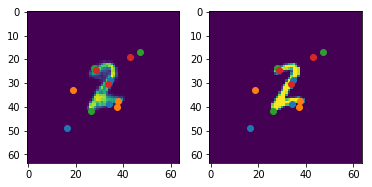

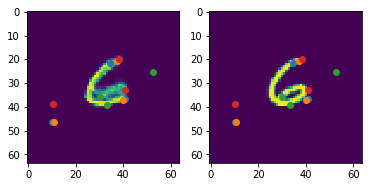

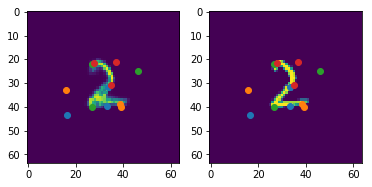

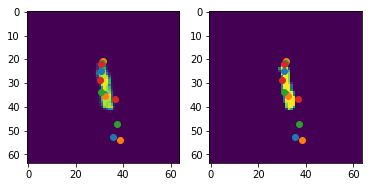

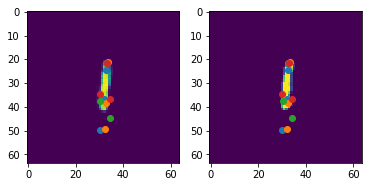

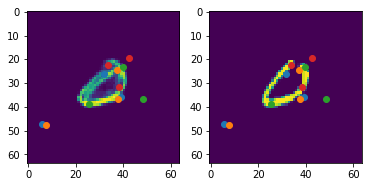

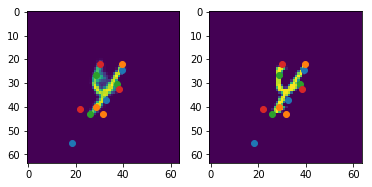

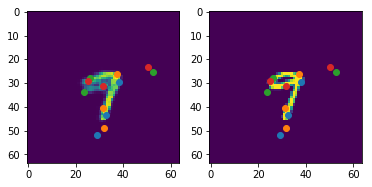

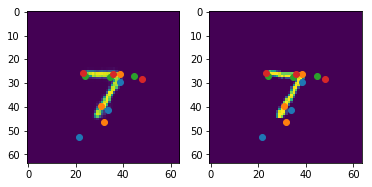

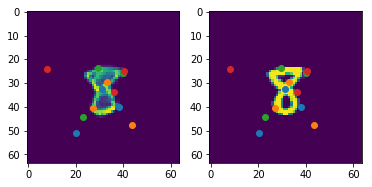

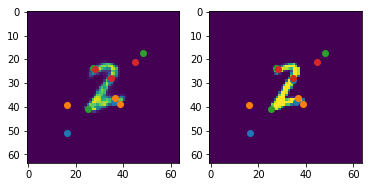

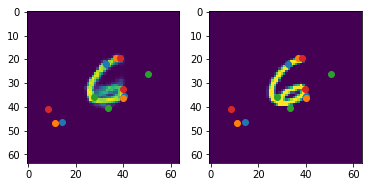

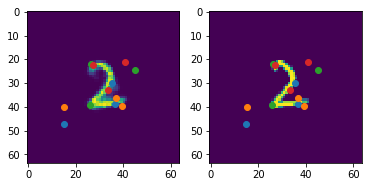

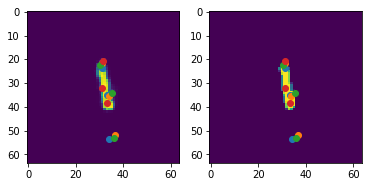

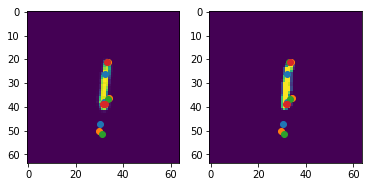

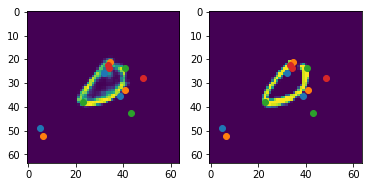

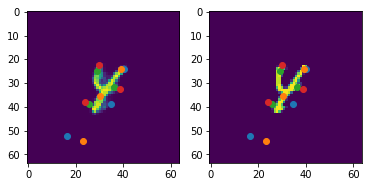

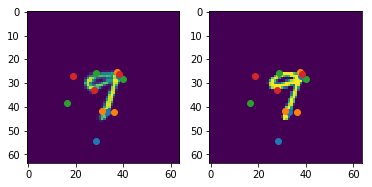

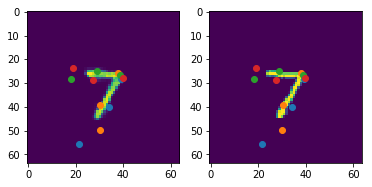

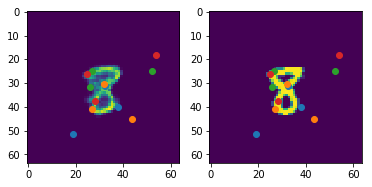

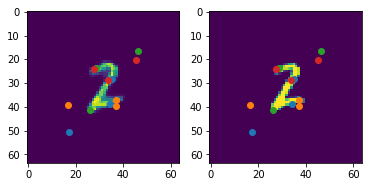

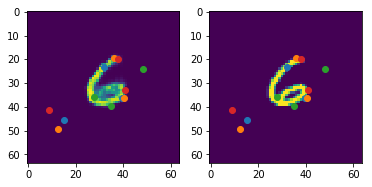

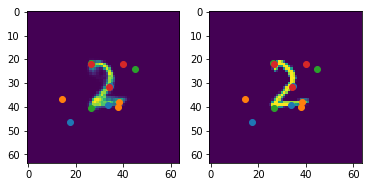

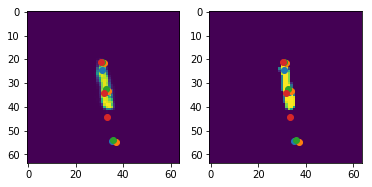

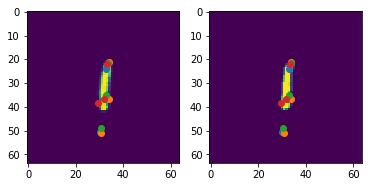

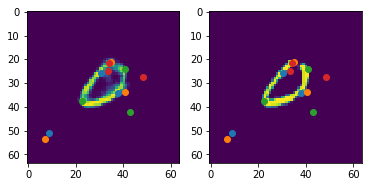

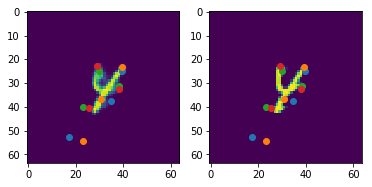

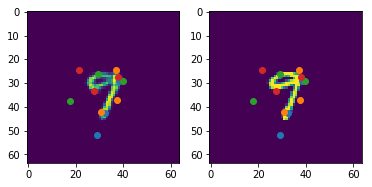

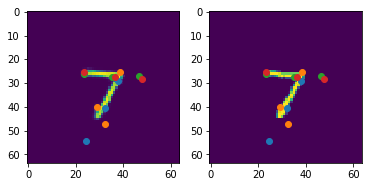

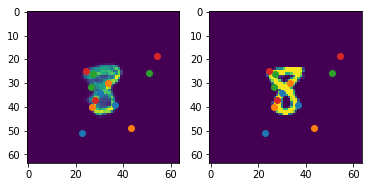

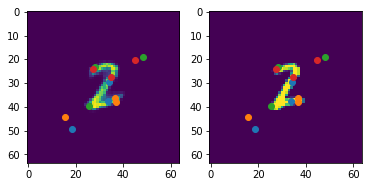

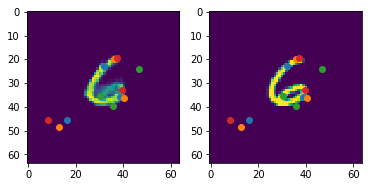

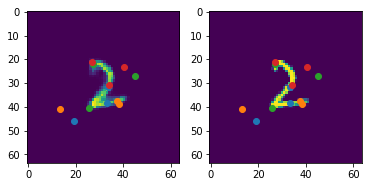

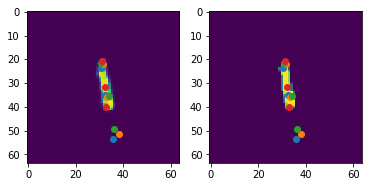

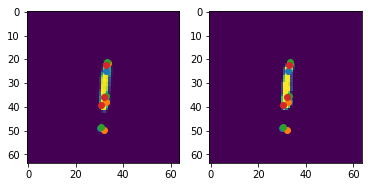

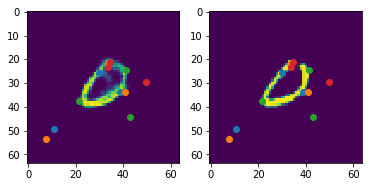

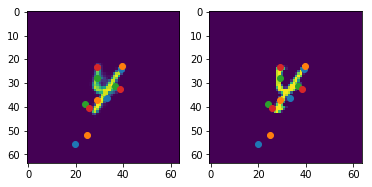

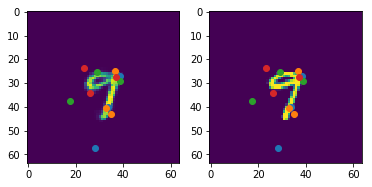

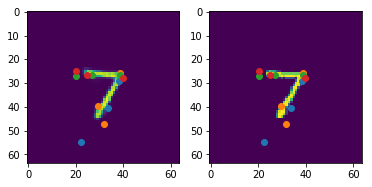

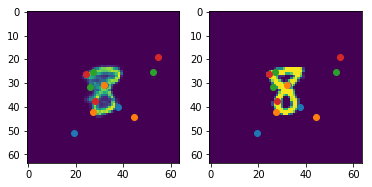

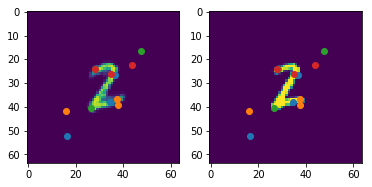

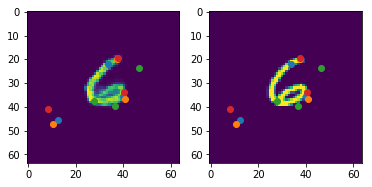

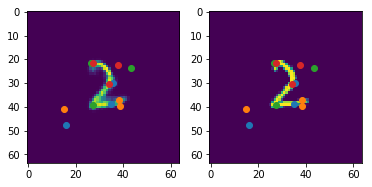

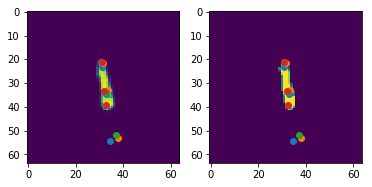

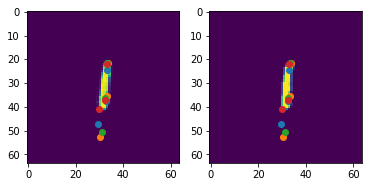

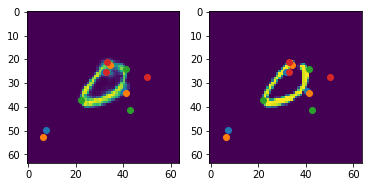

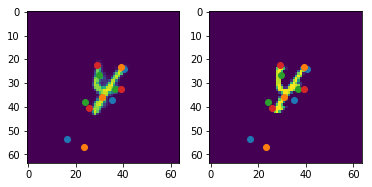

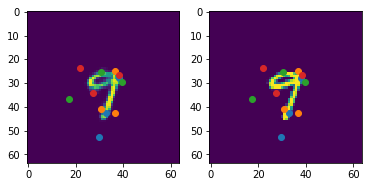

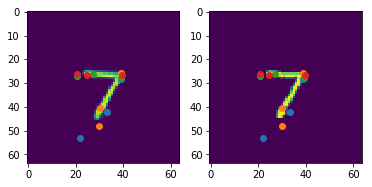

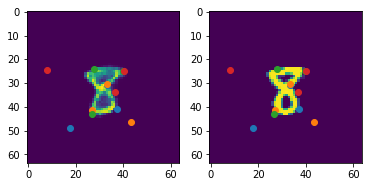

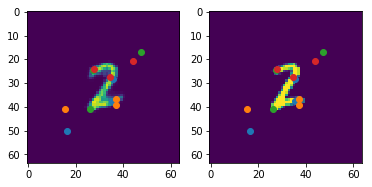

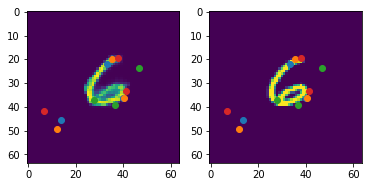

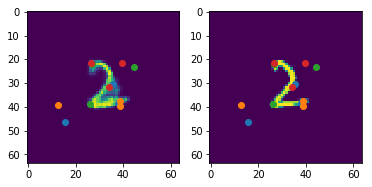

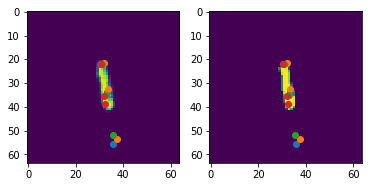

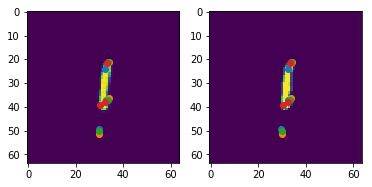

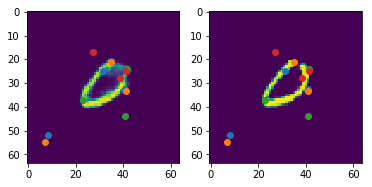

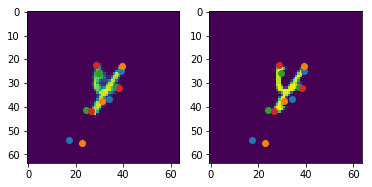

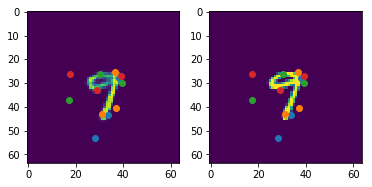

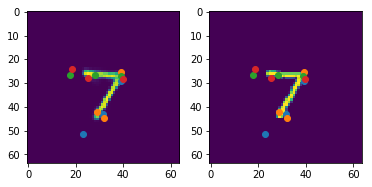

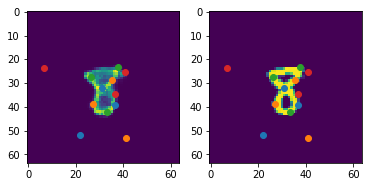

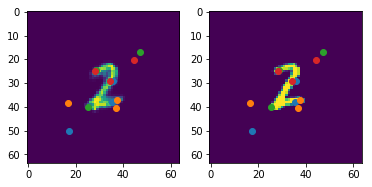

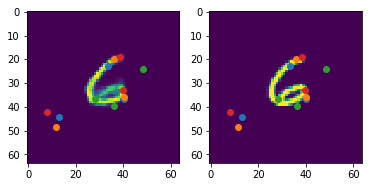

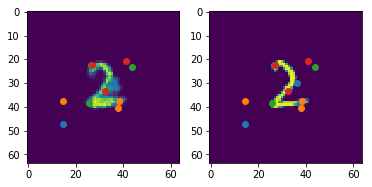

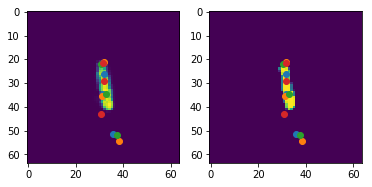

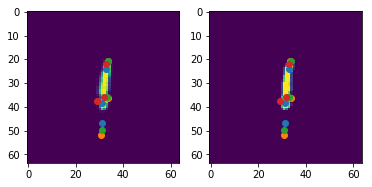

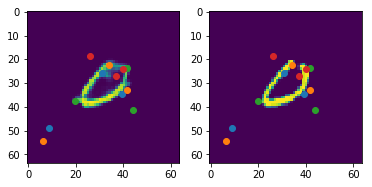

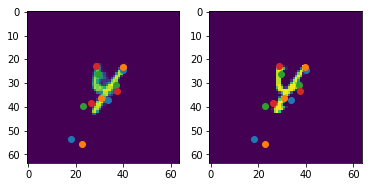

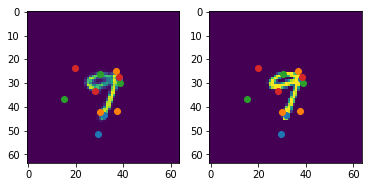

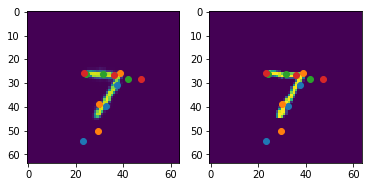

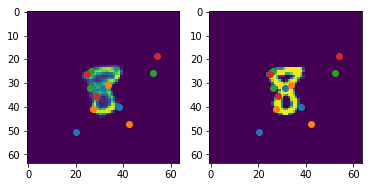

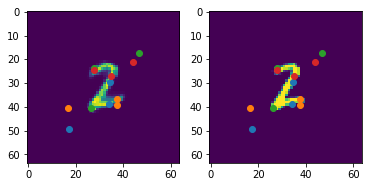

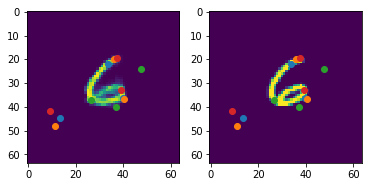

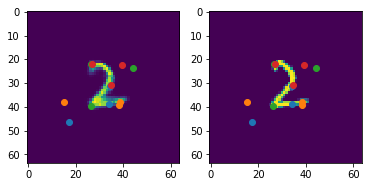

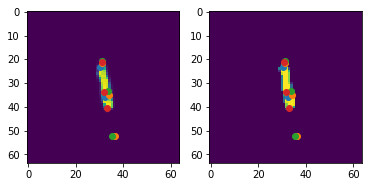

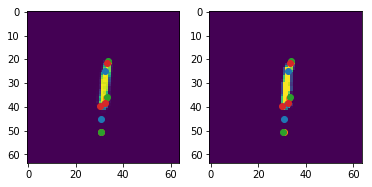

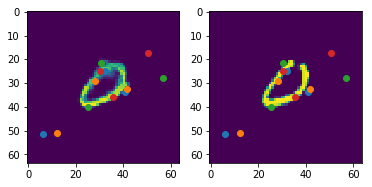

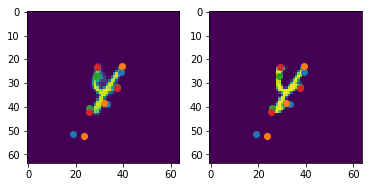

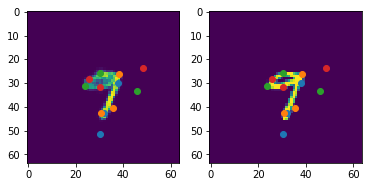

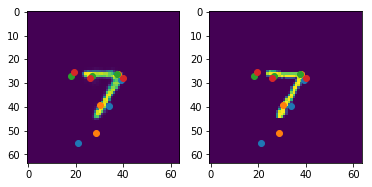

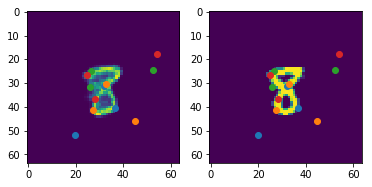

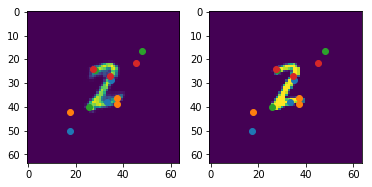

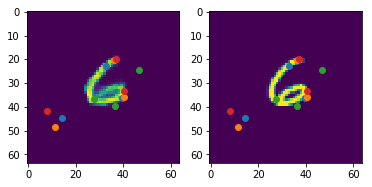

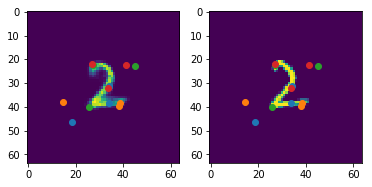

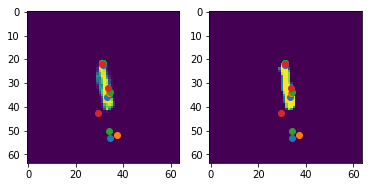

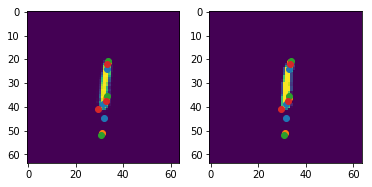

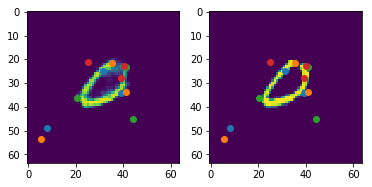

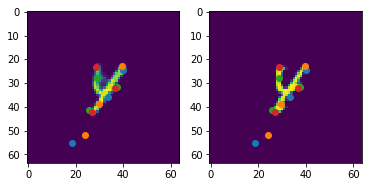

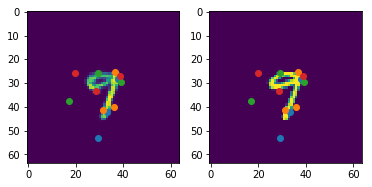

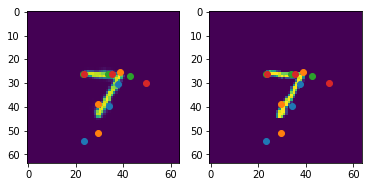

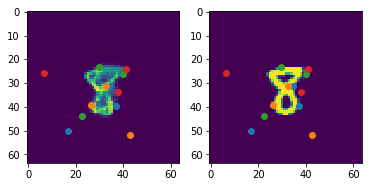

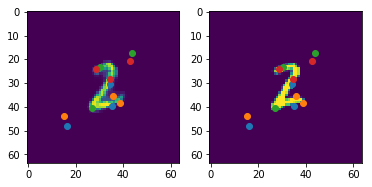

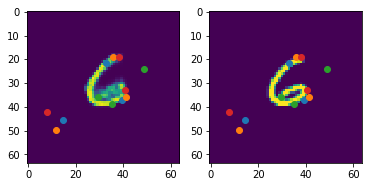

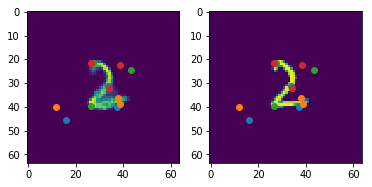

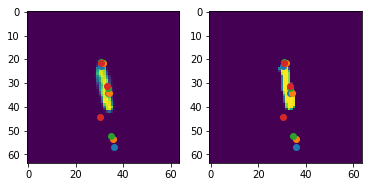

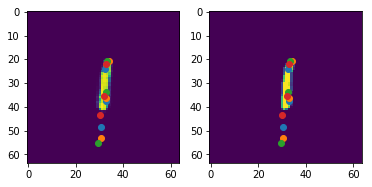

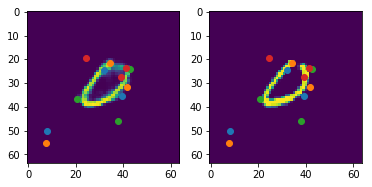

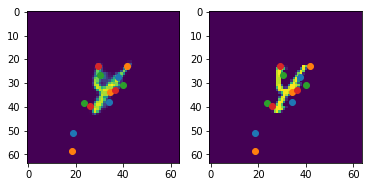

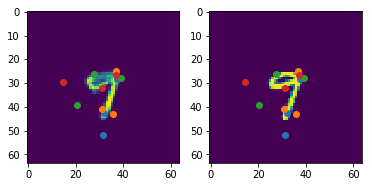

In [157]:
drawer_learn.fit(50,callbacks=[SaveModel(drawer_learn)])

/home/wgoldie/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/wgoldie/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Total time: 2:42:16
epoch  train loss  valid loss
0      0.024916    0.024661    (01:02)
1      0.024205    0.024545    (01:04)
2      0.024277    0.024432    (01:02)
3      0.024276    0.024336    (01:03)
4      0.024160    0.024295    (01:03)
5      0.024279    0.024272    (01:03)
6      0.024316    0.024353    (01:03)
7      0.024377    0.024354    (01:02)
8      0.024112    0.024187    (01:03)
9      0.023887    0.024046    (01:03)
10     0.023921    0.023985    (01:02)
11     0.024018    0.024075    (01:03)
12     0.023885    0.023967    (01:02)
13     0.023909    0.024025    (01:03)
14     0.023582    0.023858    (01:02)
15     0.023554    0.023801    (01:02)
16     0.023604    0.023858    (01:03)
17     0.023586    0.023771    (01:01)
18     0.023669    0.023842    (01:02)
19     0.023653    0.023751    (01:02)
20     0.023547    0.023709    (01:02)
21     0.023534    0.023682    (01:04)
22     0.023371    0.023632    (01:03)
23     0.023515    0.023732    (01:02)
24     0.02364

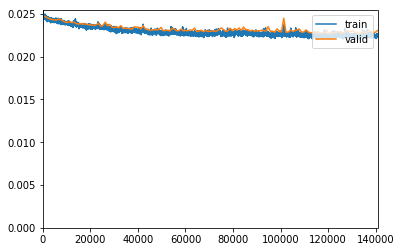

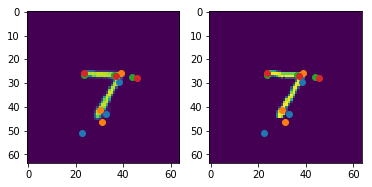

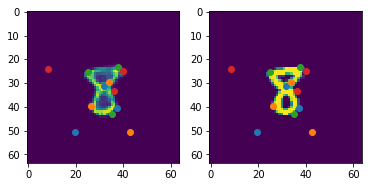

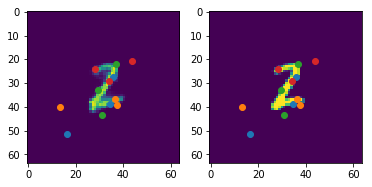

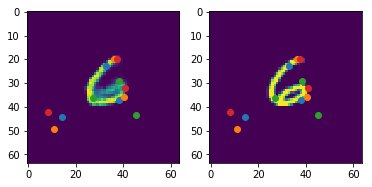

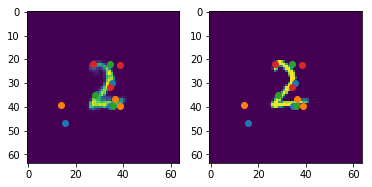

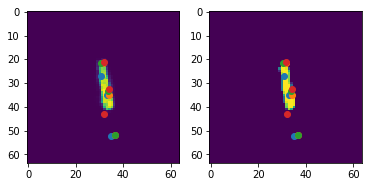

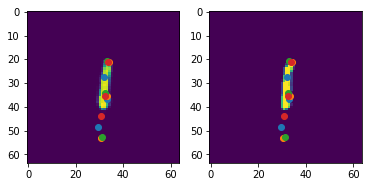

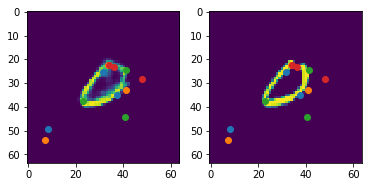

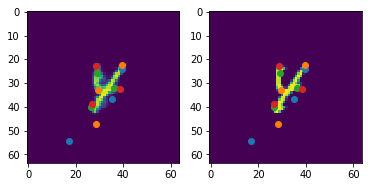

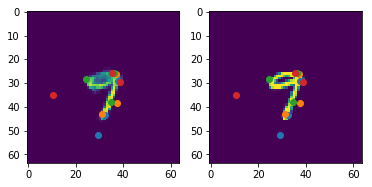

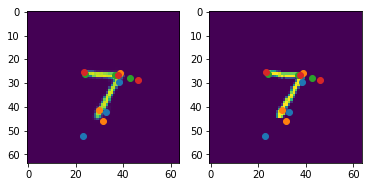

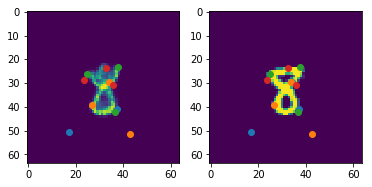

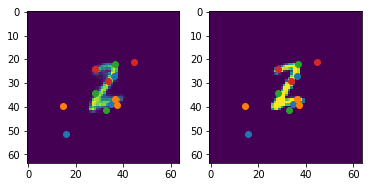

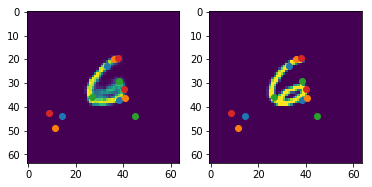

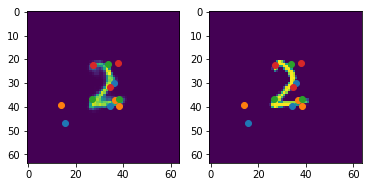

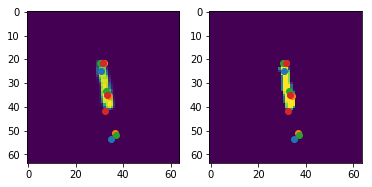

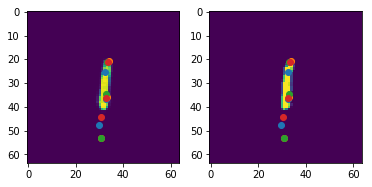

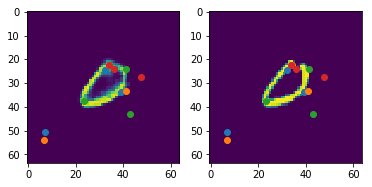

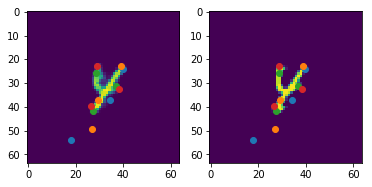

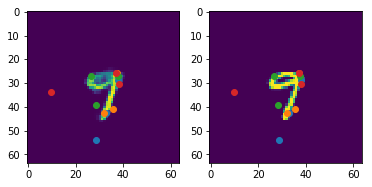

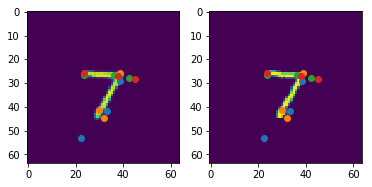

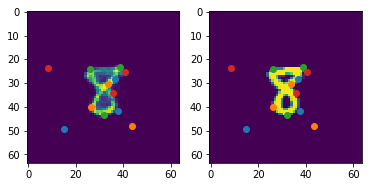

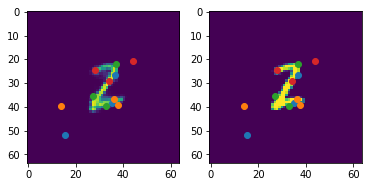

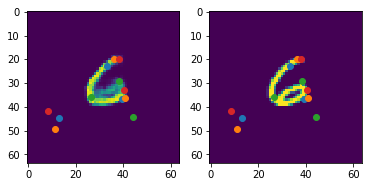

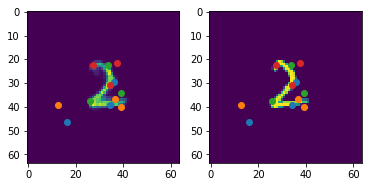

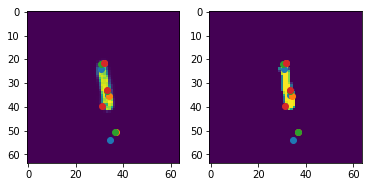

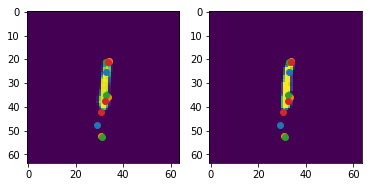

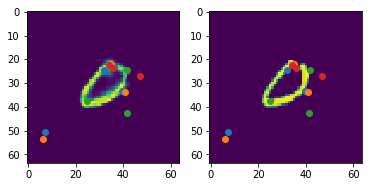

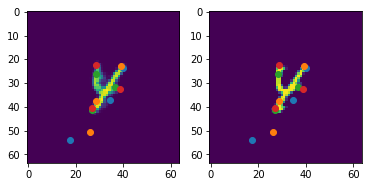

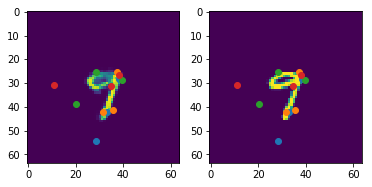

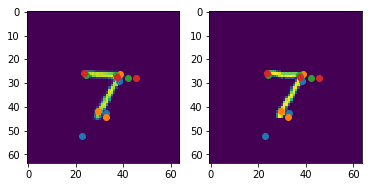

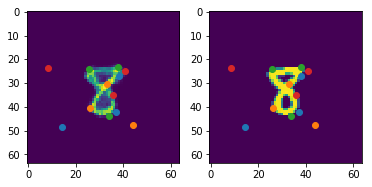

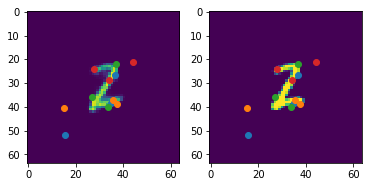

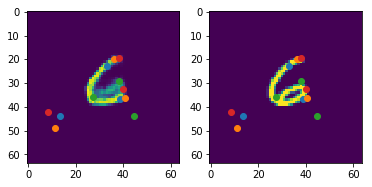

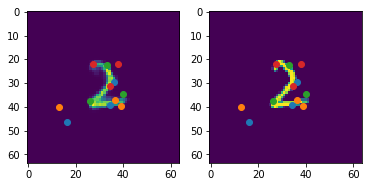

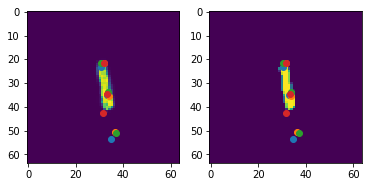

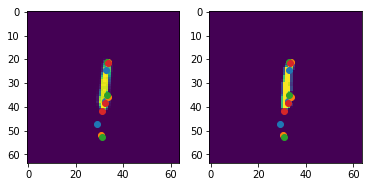

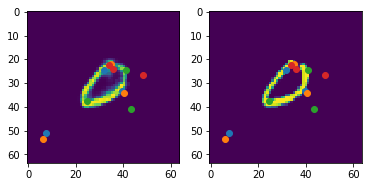

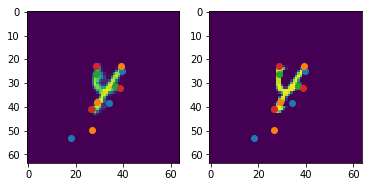

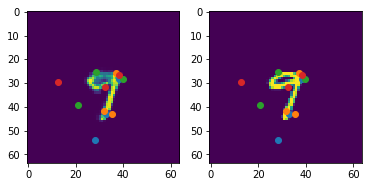

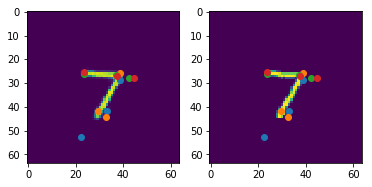

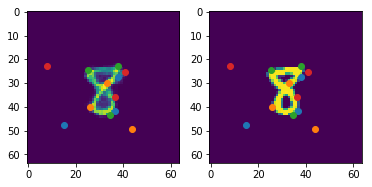

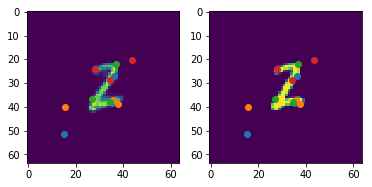

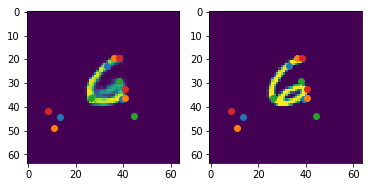

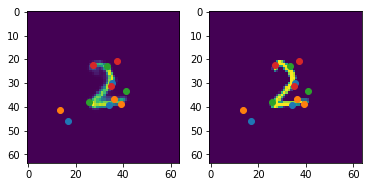

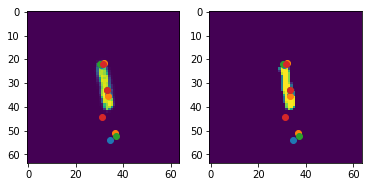

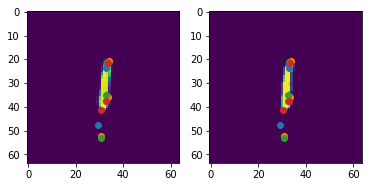

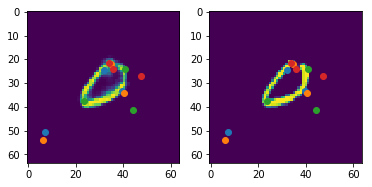

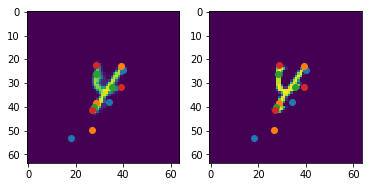

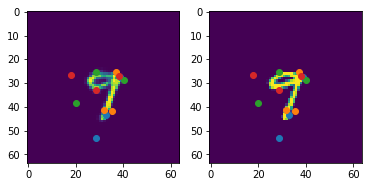

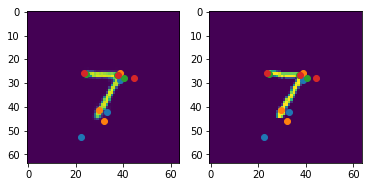

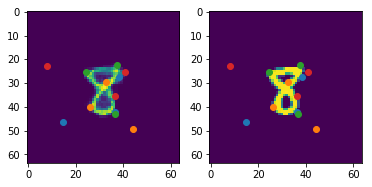

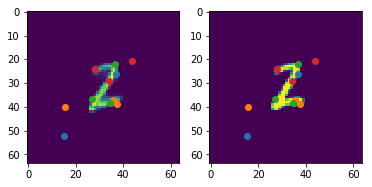

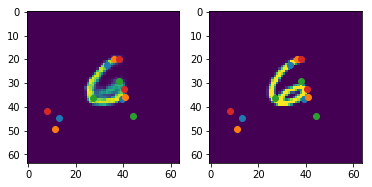

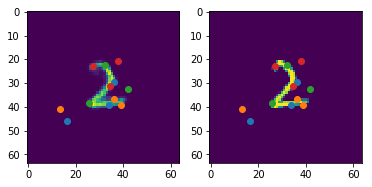

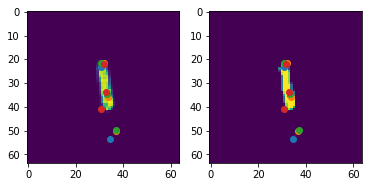

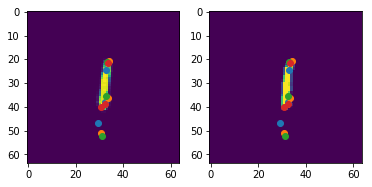

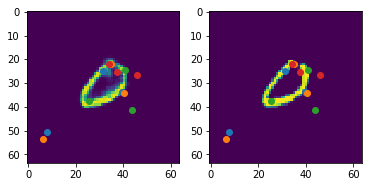

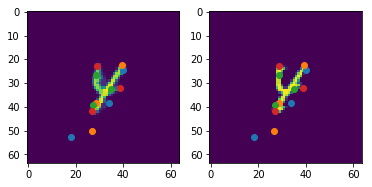

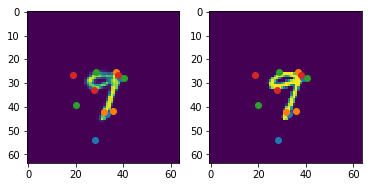

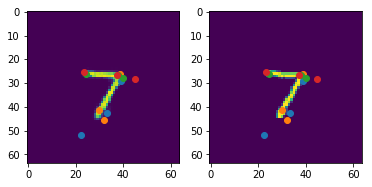

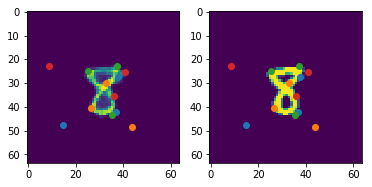

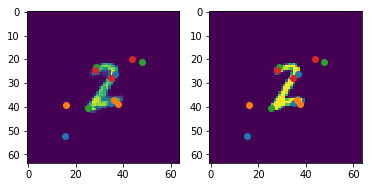

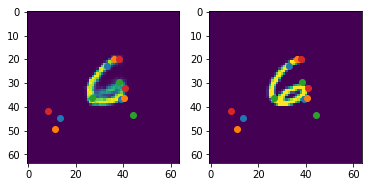

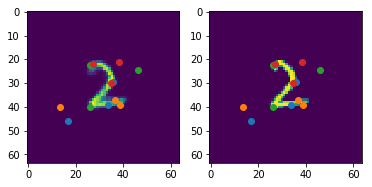

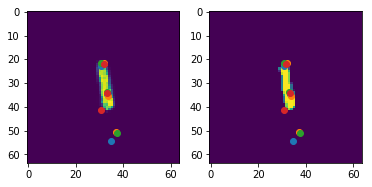

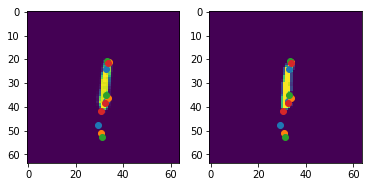

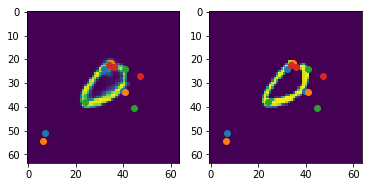

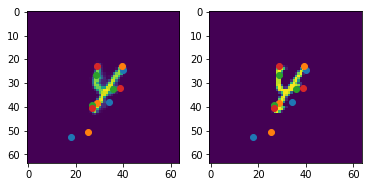

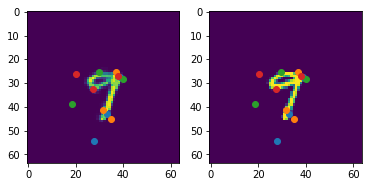

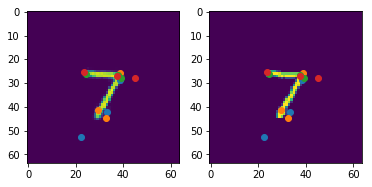

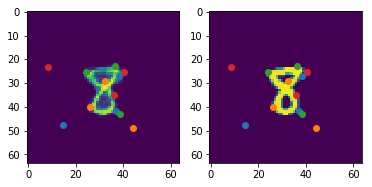

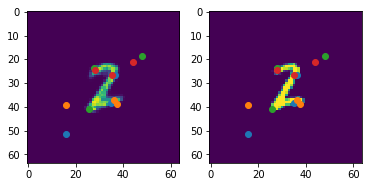

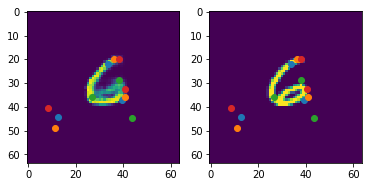

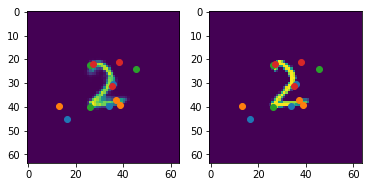

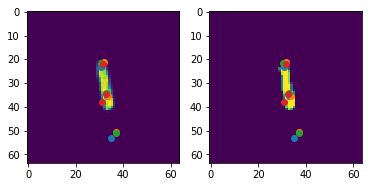

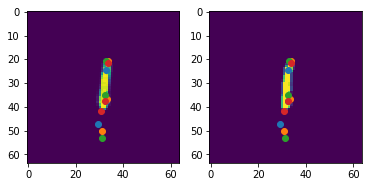

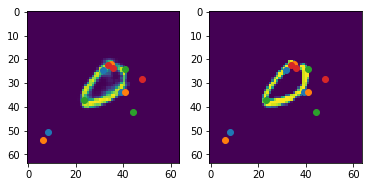

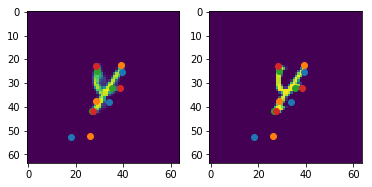

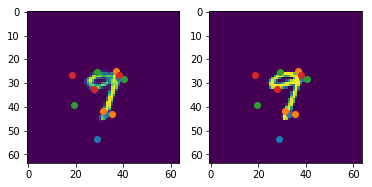

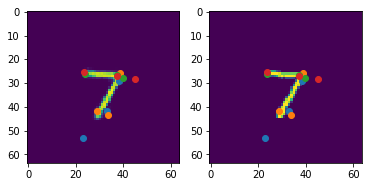

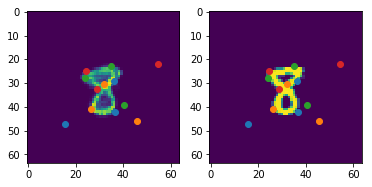

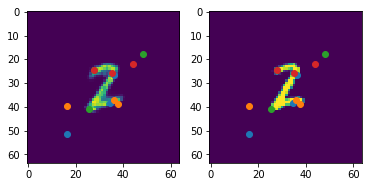

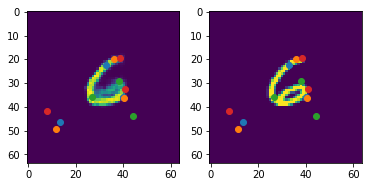

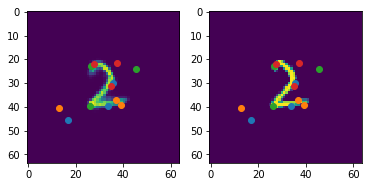

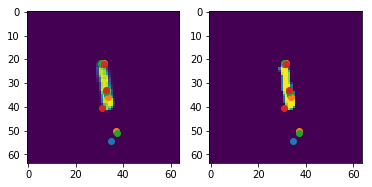

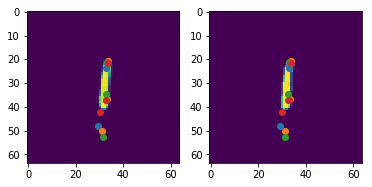

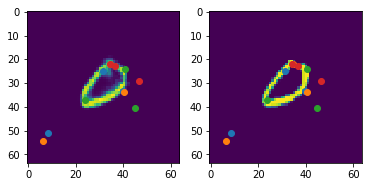

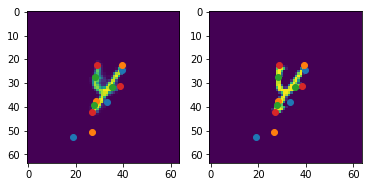

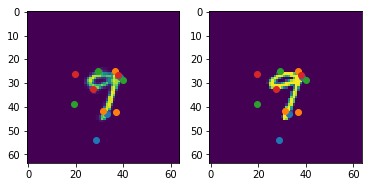

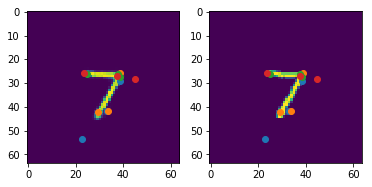

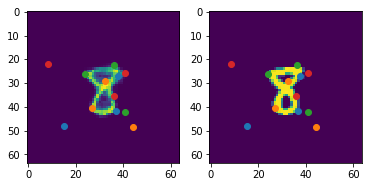

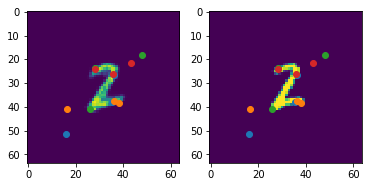

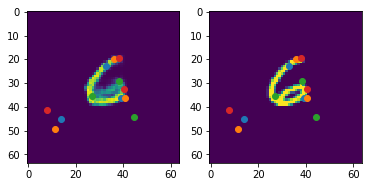

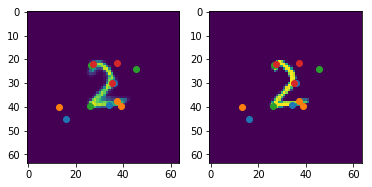

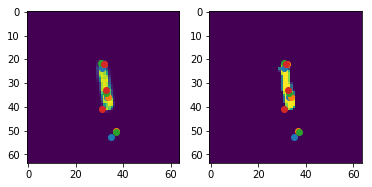

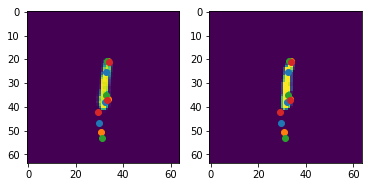

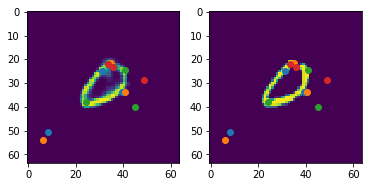

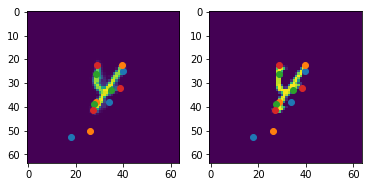

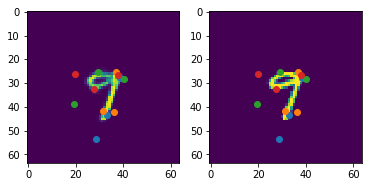

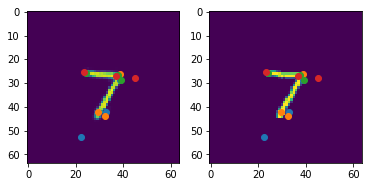

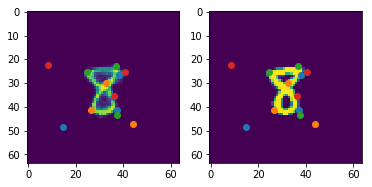

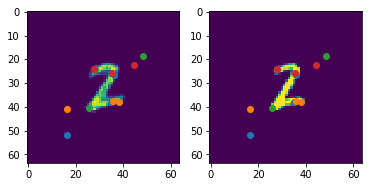

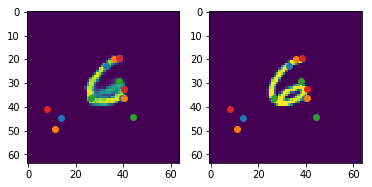

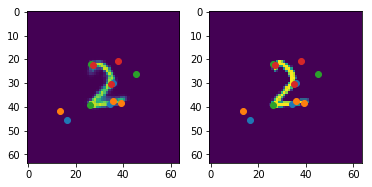

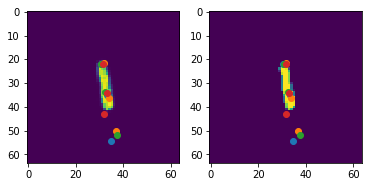

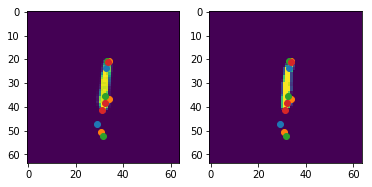

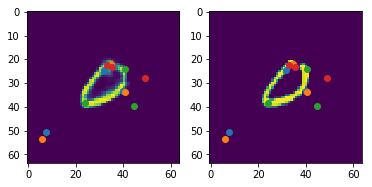

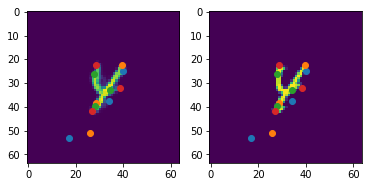

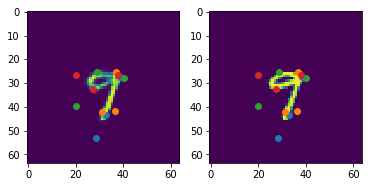

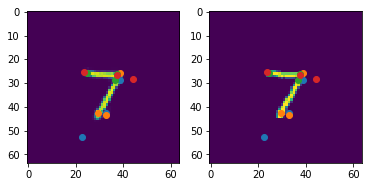

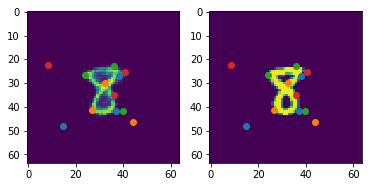

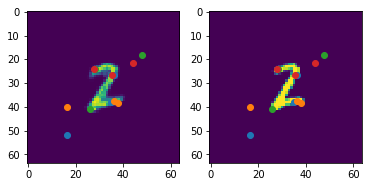

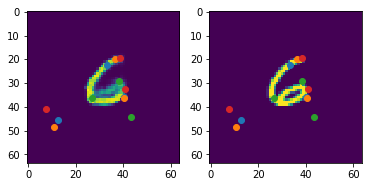

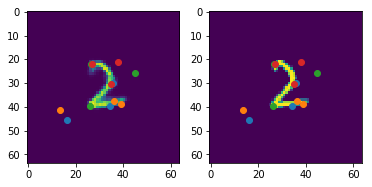

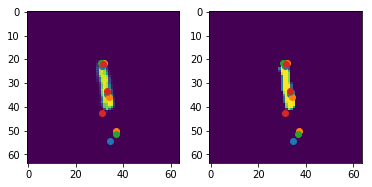

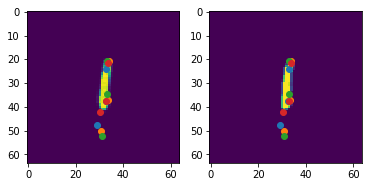

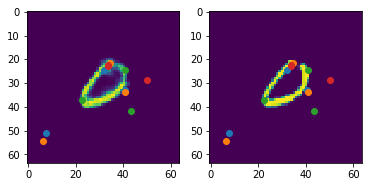

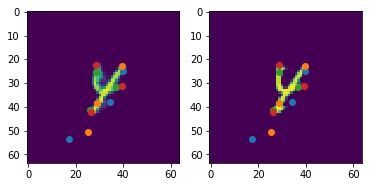

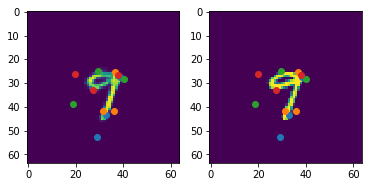

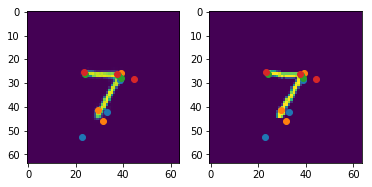

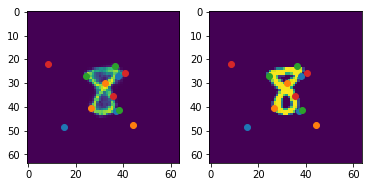

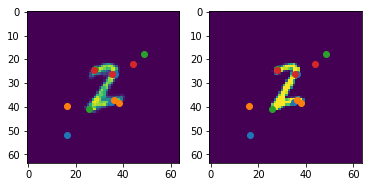

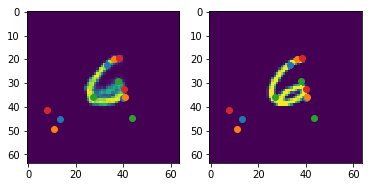

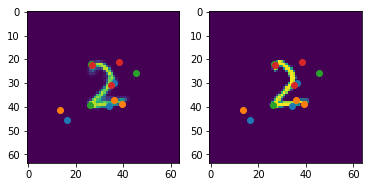

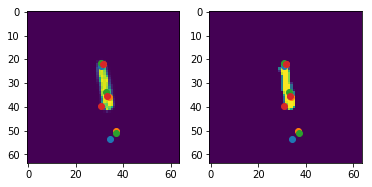

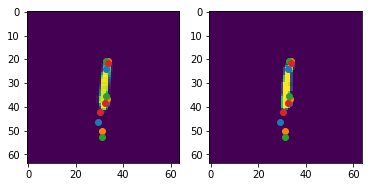

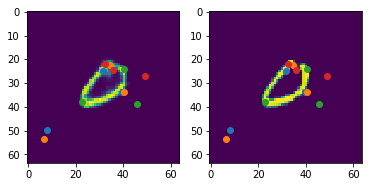

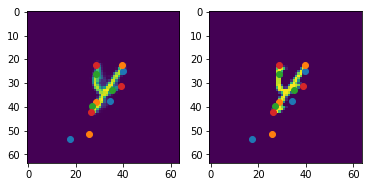

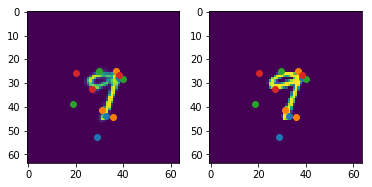

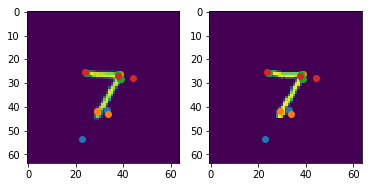

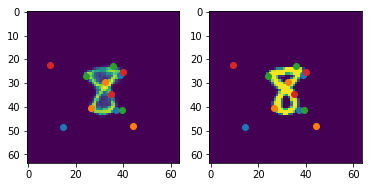

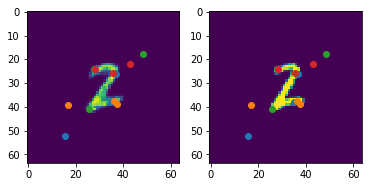

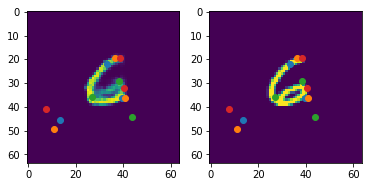

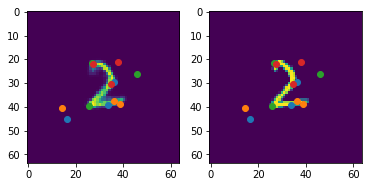

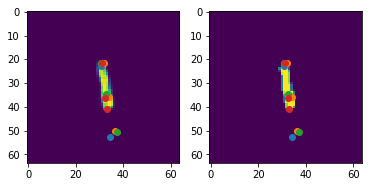

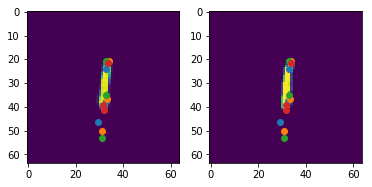

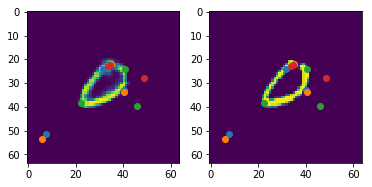

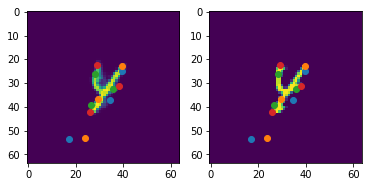

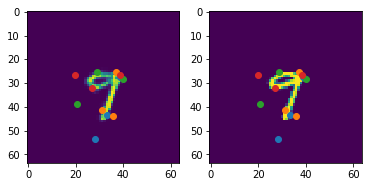

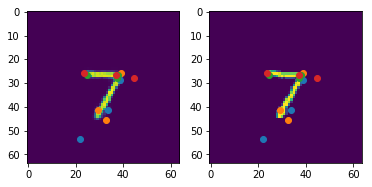

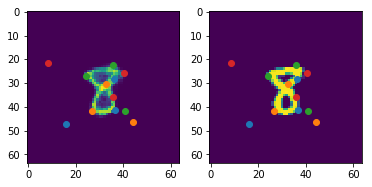

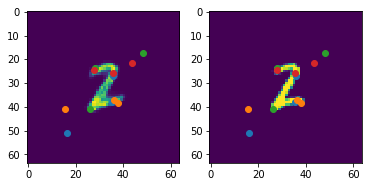

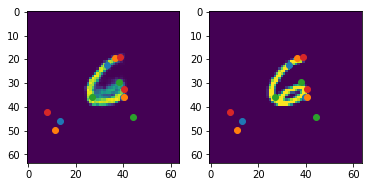

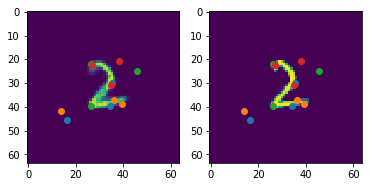

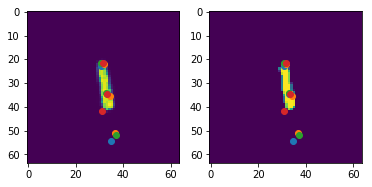

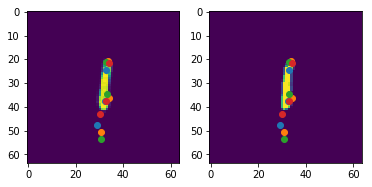

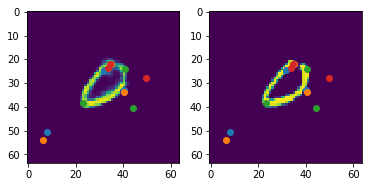

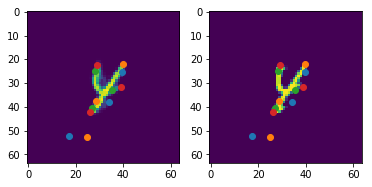

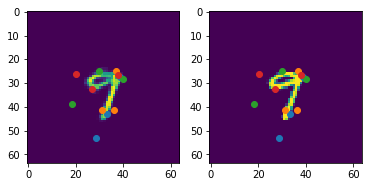

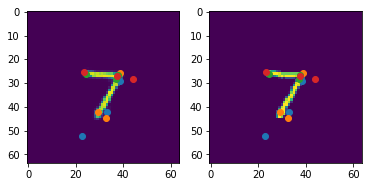

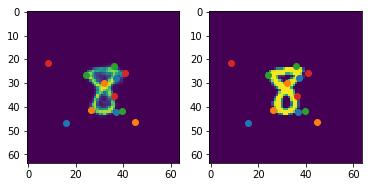

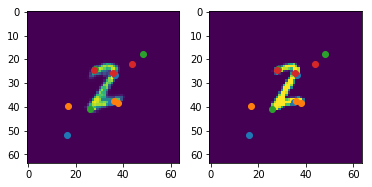

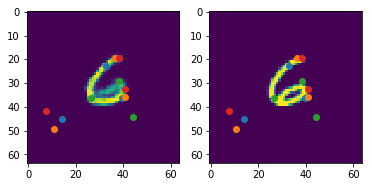

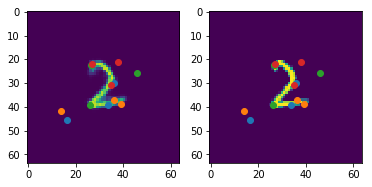

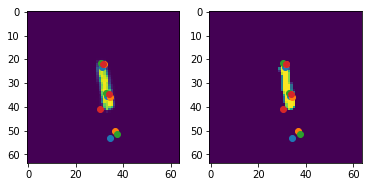

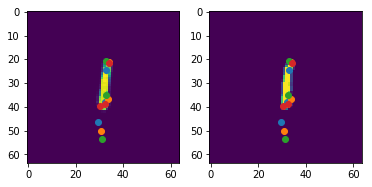

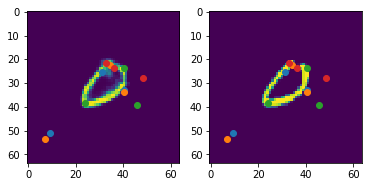

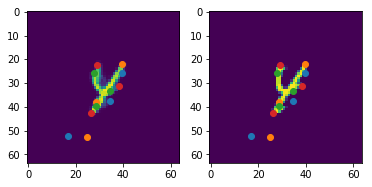

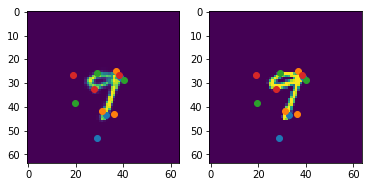

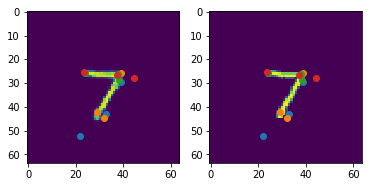

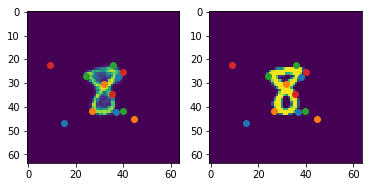

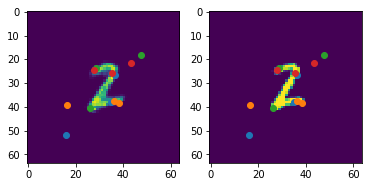

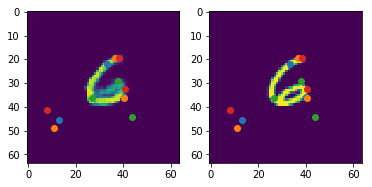

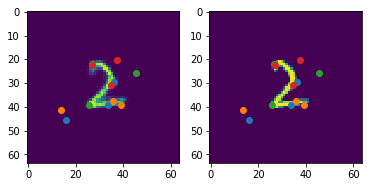

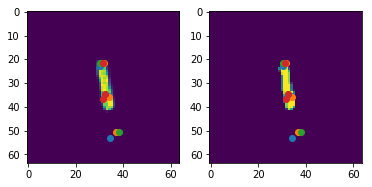

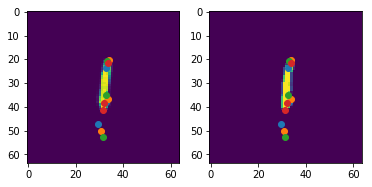

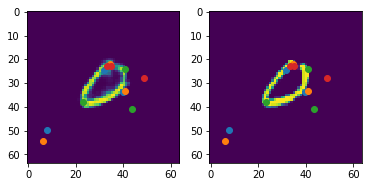

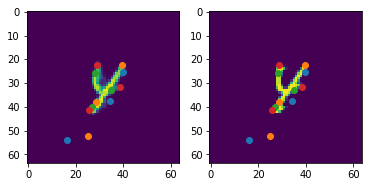

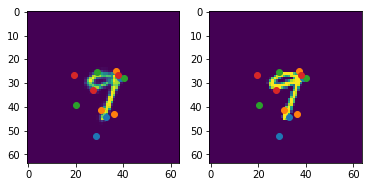

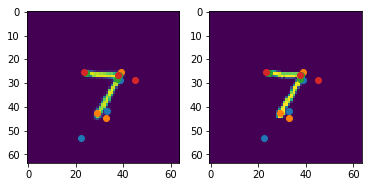

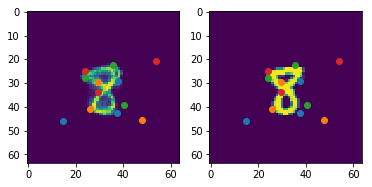

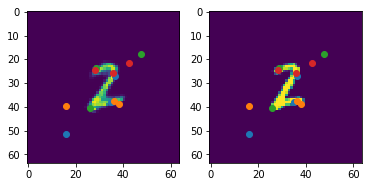

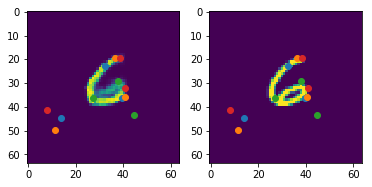

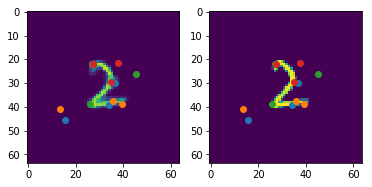

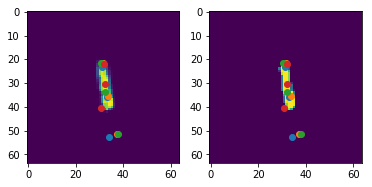

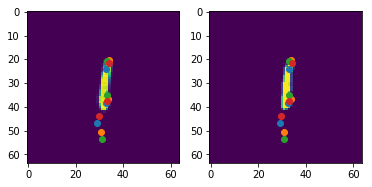

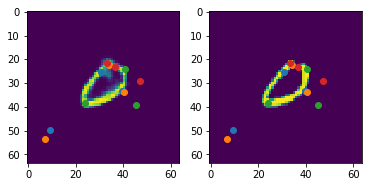

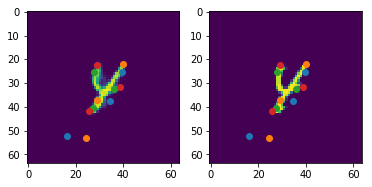

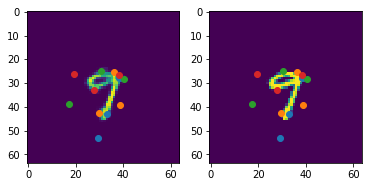

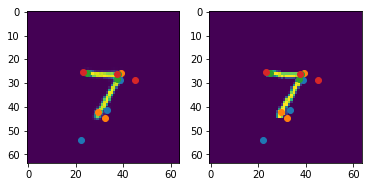

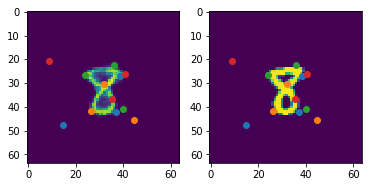

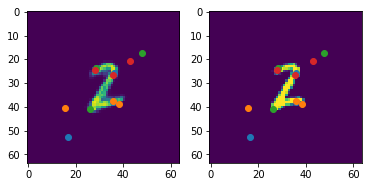

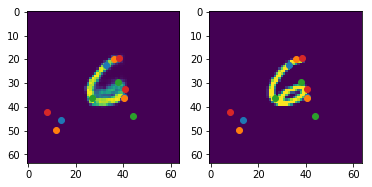

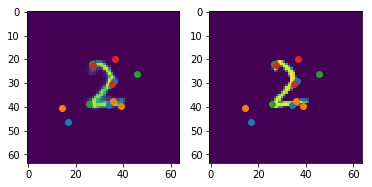

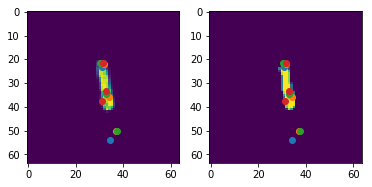

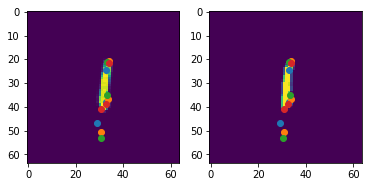

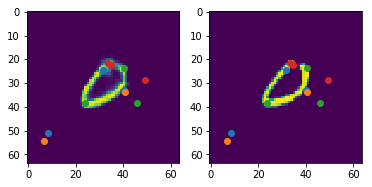

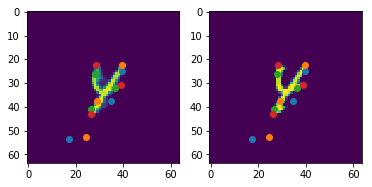

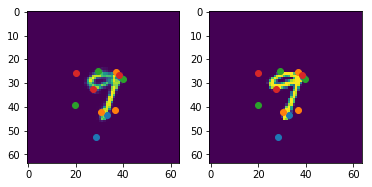

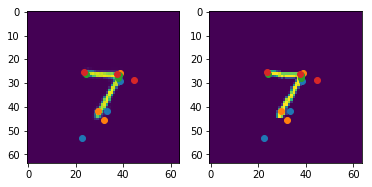

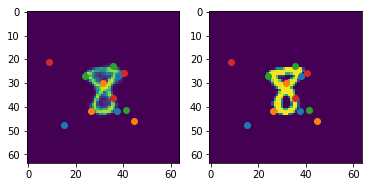

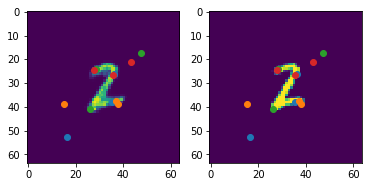

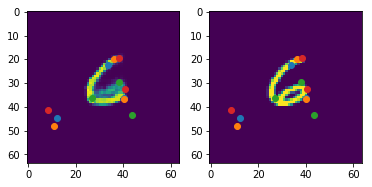

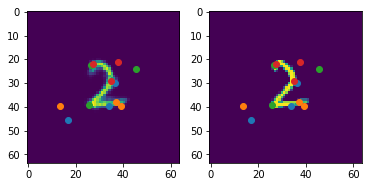

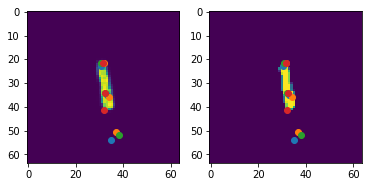

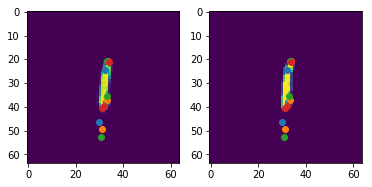

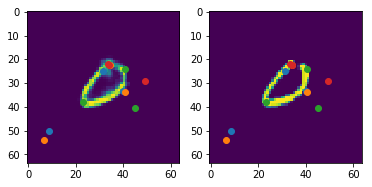

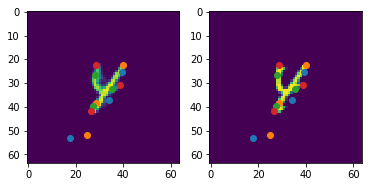

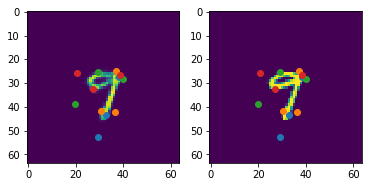

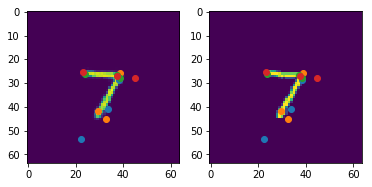

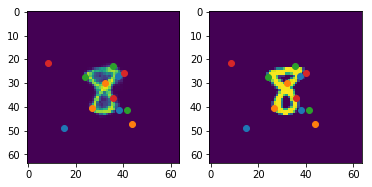

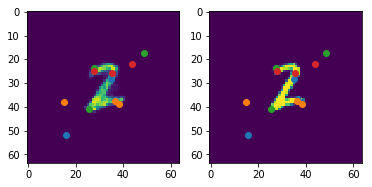

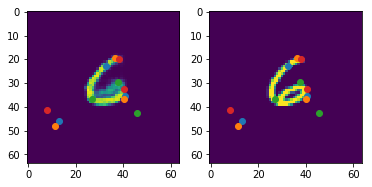

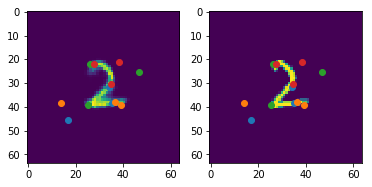

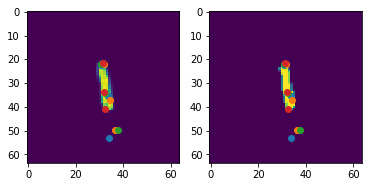

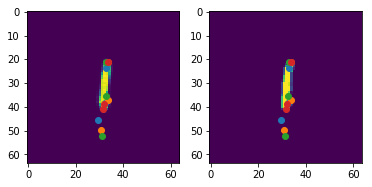

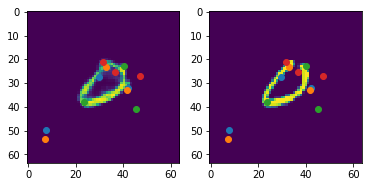

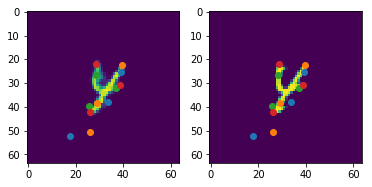

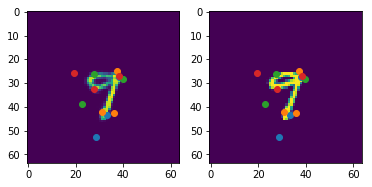

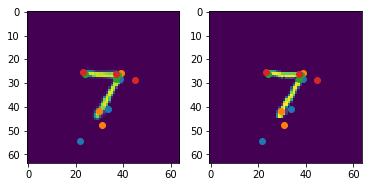

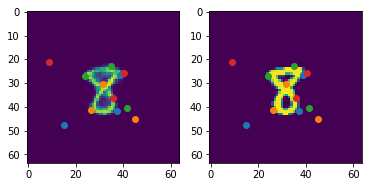

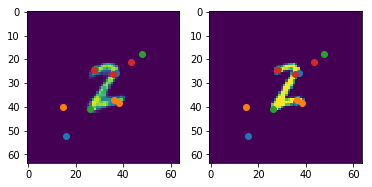

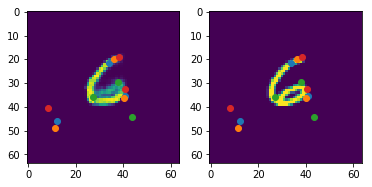

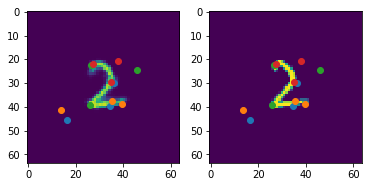

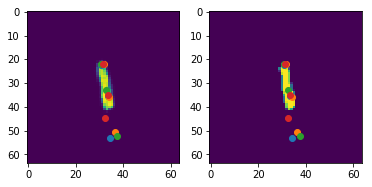

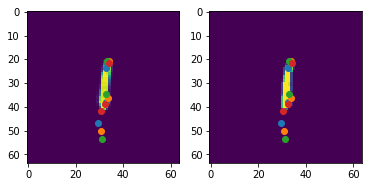

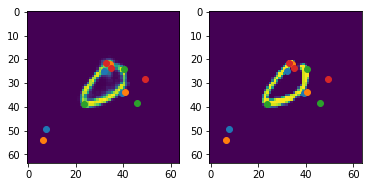

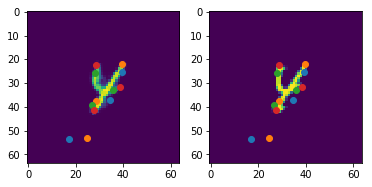

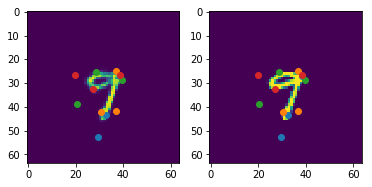

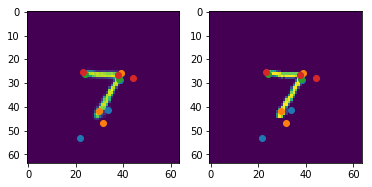

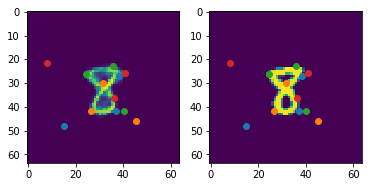

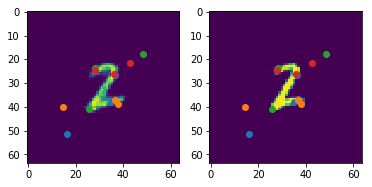

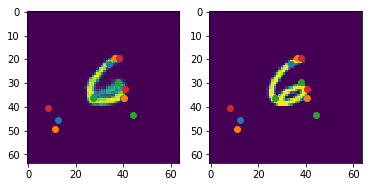

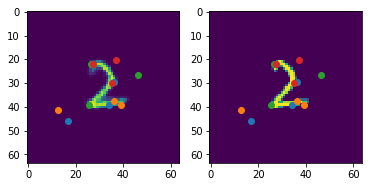

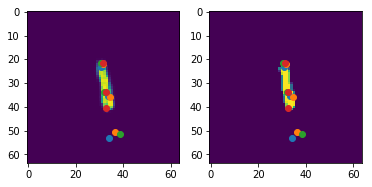

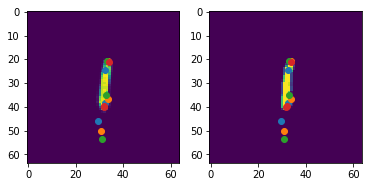

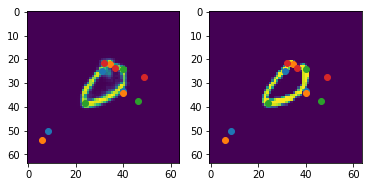

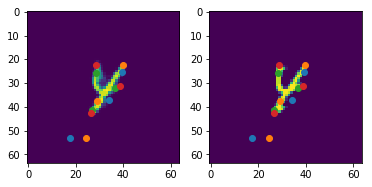

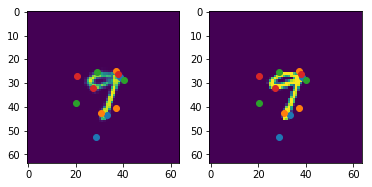

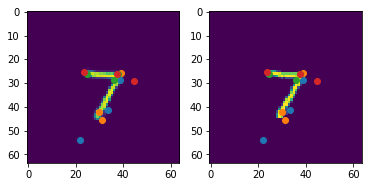

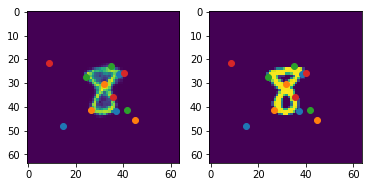

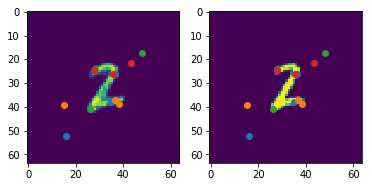

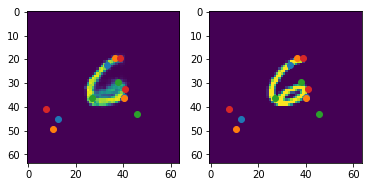

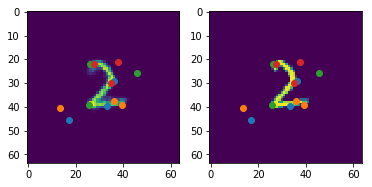

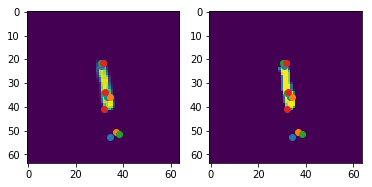

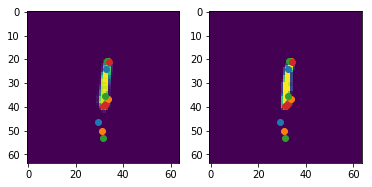

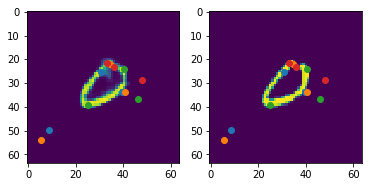

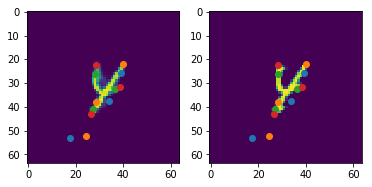

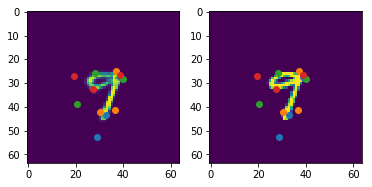

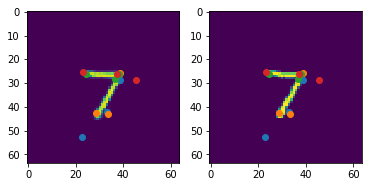

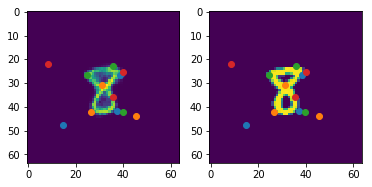

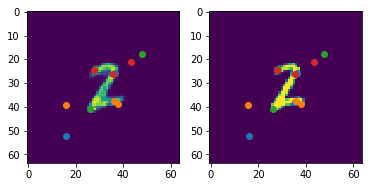

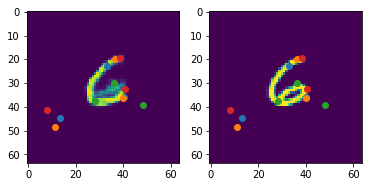

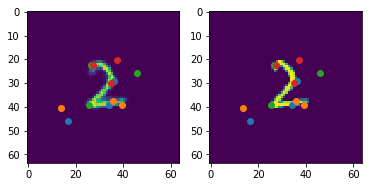

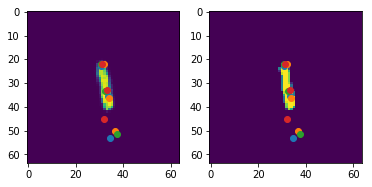

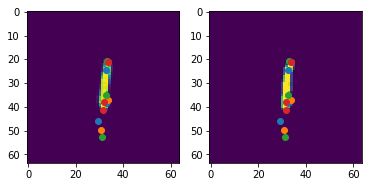

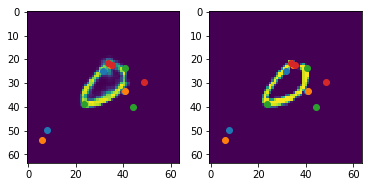

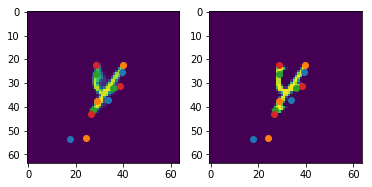

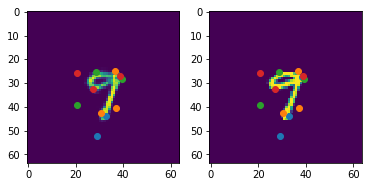

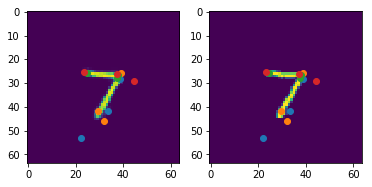

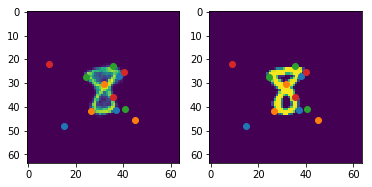

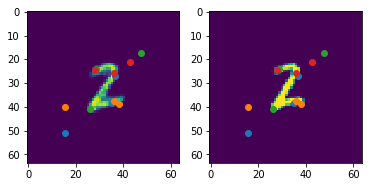

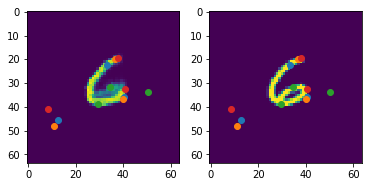

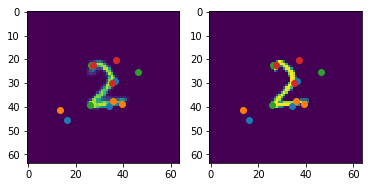

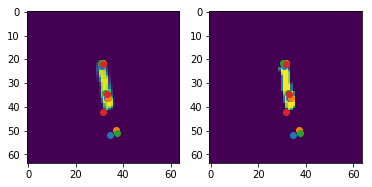

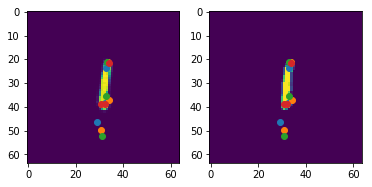

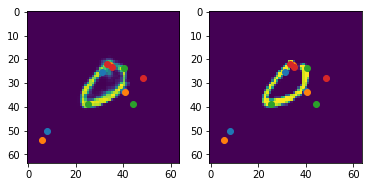

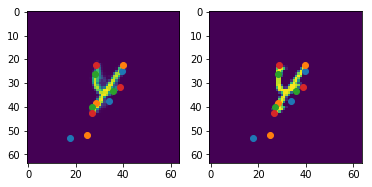

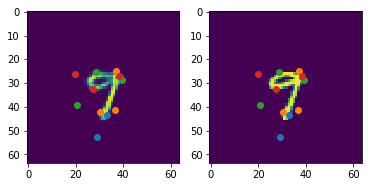

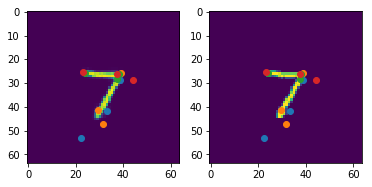

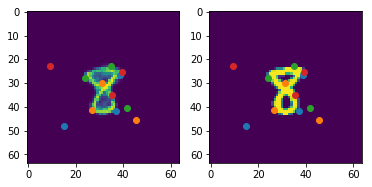

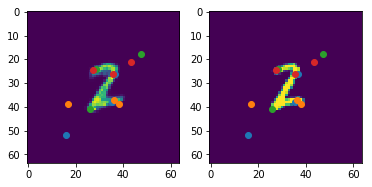

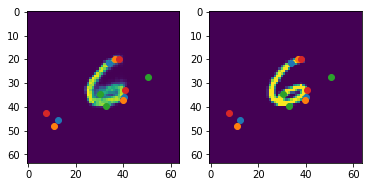

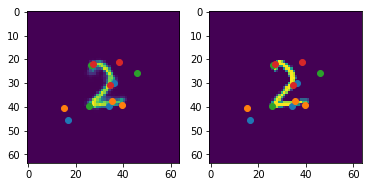

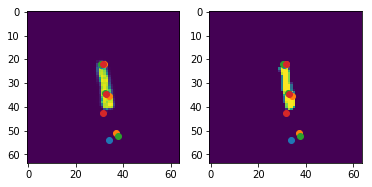

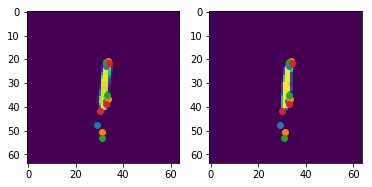

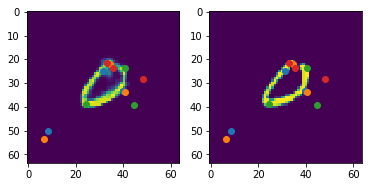

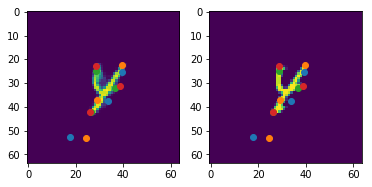

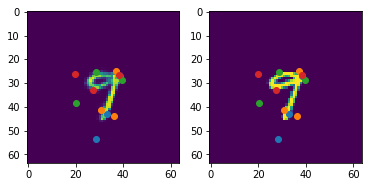

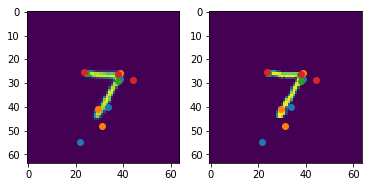

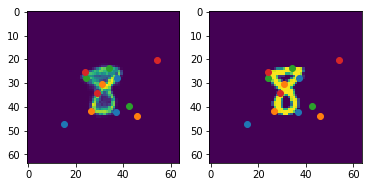

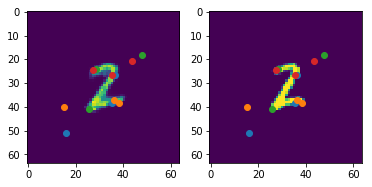

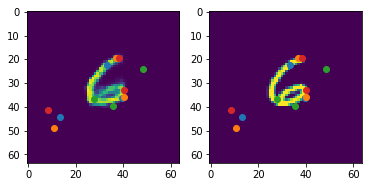

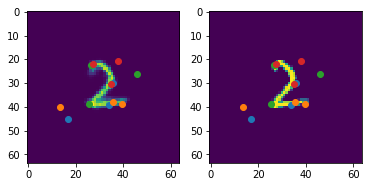

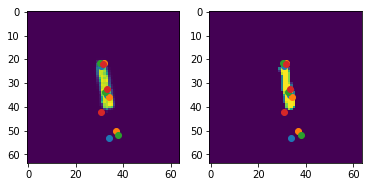

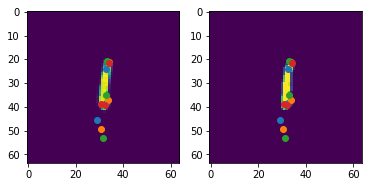

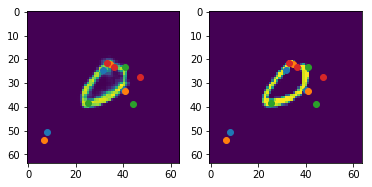

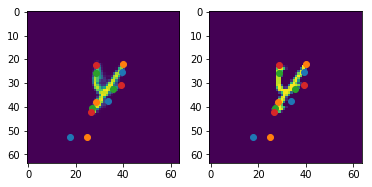

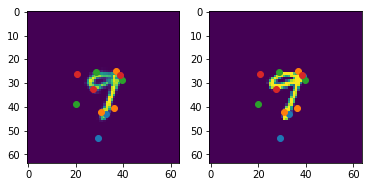

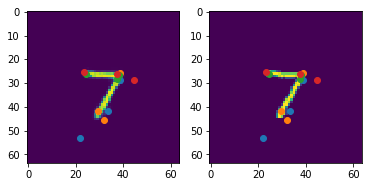

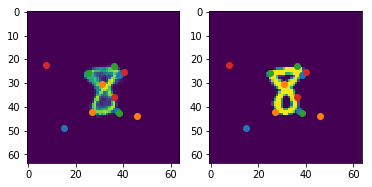

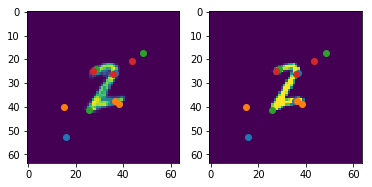

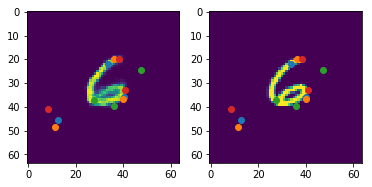

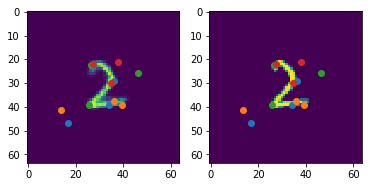

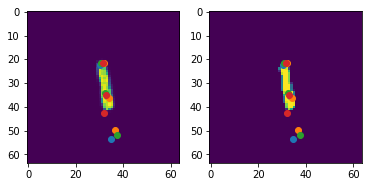

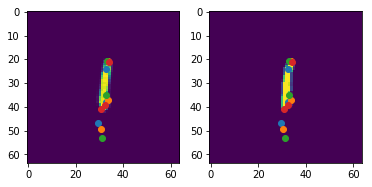

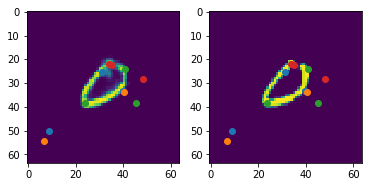

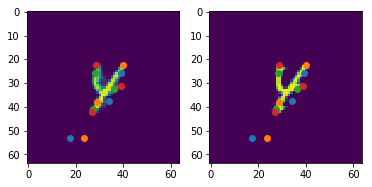

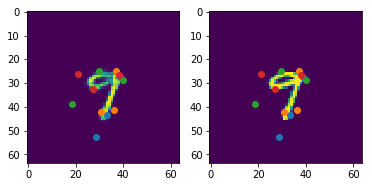

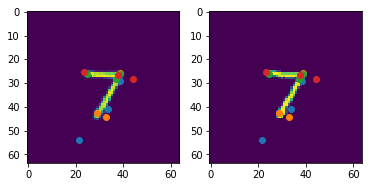

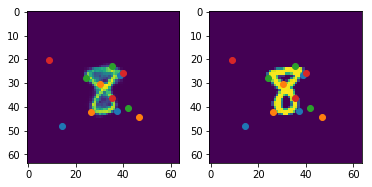

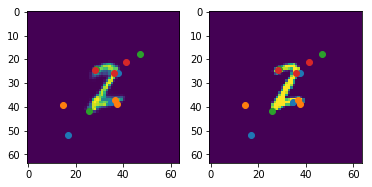

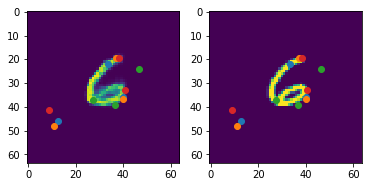

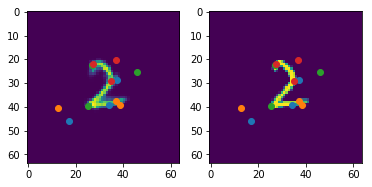

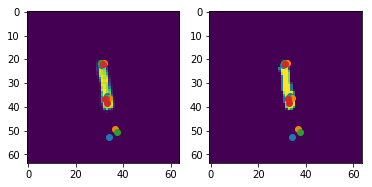

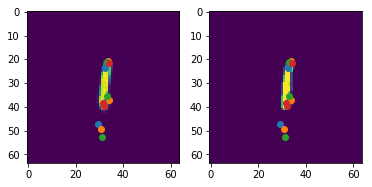

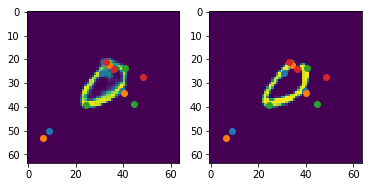

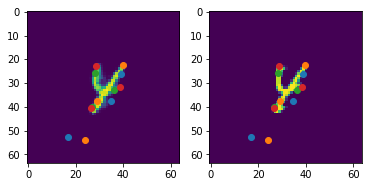

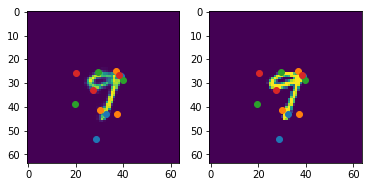

In [156]:
drawer_learn.fit(150, 0.0005, callbacks=[SaveModel(drawer_learn)])

In [32]:
drawer_learn.load('mnist-works-226')

In [84]:
def plot_drawer_actions(learn, batch_iter):
    Xs = next(batch_iter)[0]

    for it in range(10):
        X = Xs[it]
        X_np = to_np(X[0].detach().reshape((64,64)))
        fig, ax = plt.subplots(1,3, figsize=(8,8))
        im, acts = learn.model(X.unsqueeze(0).cuda())
        im_np = to_np(im.detach().reshape((64,64)))
        acts_np = to_np(acts.detach().squeeze()) * 64
        
        ax[0].imshow(im_np)
        ax[0].set_title('reconstructed')
        ax[1].imshow(im_np)
        ax[1].set_title('original + bezier latents')
        ax[2].imshow(X_np)
        ax[2].set_title('original')
        
        for i in range(acts_np.shape[0]):
            points = list(zip(acts_np[i, 0::2], acts_np[i, 1::2]))
            ax[1].scatter(acts_np[i, 0::2], acts_np[i, 1::2])
            pth = mpatches.PathPatch(
                Path(
                    points,
                    [Path.MOVETO, Path.CURVE3, Path.CURVE3]
                ),
                fc=None, 
                fill=False,
                transform=ax[1].transData
            )
            ax[1].add_patch(pth)

        fig.show()

/home/wgoldie/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


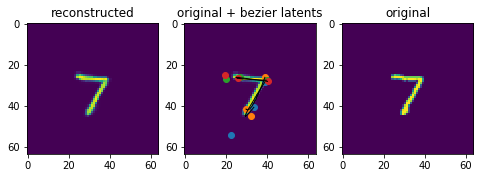

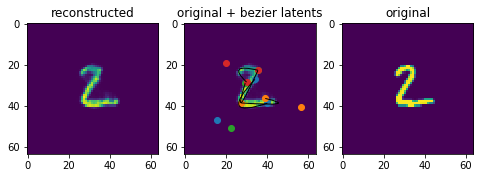

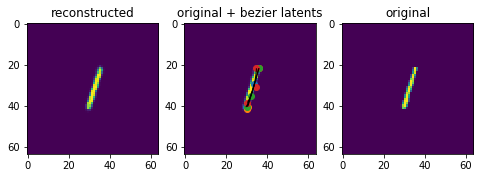

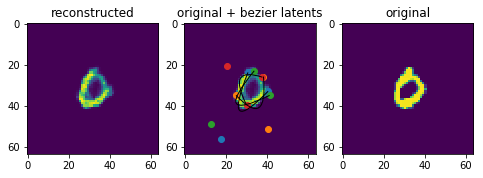

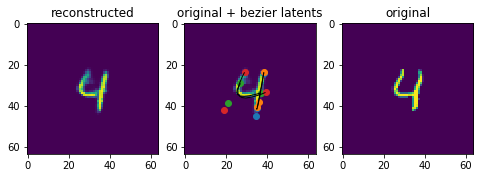

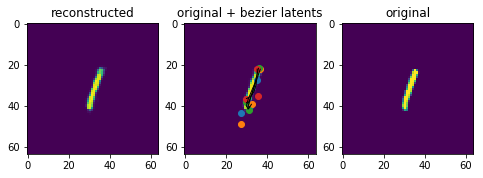

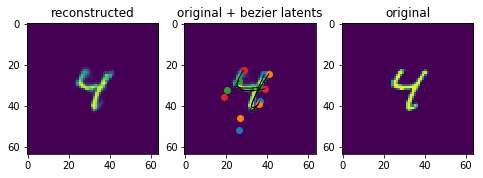

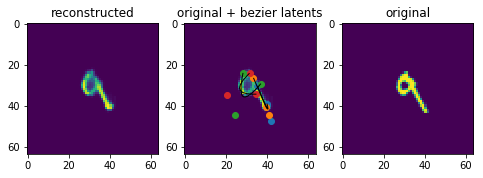

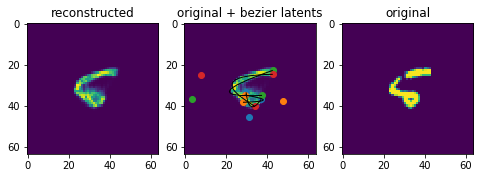

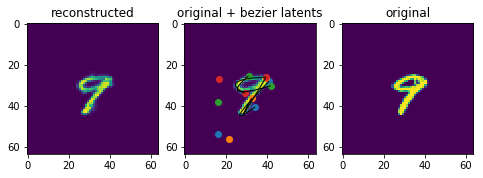

In [85]:
plot_drawer_actions(drawer_learn, iter(drawer_learn.data.valid_dl))